# Make Prediction Plots

Want to create 2 plots:
- A plot of the 70 cells with error bars, and real values
- Something else

## Setup

In [1]:
import torch
import torch.nn as nn

from os import listdir
from os.path import join

import matplotlib.pyplot as plt

import sys
sys.path.append('../')
import utils

In [2]:
assert torch.cuda.is_available(), 'CUDA is not available.'

## Load some data

So I forgot to split data into global test and training sets. So will need to do that down the road. 

In [3]:
fname = join('/home/squirt/Documents/data/weather_data/', 'all_data.h5')

In [4]:
batch_size = 160 
split = 0.5
_, v_dl = utils.get_dataloaders(fname, batch_size, split)

## Load the models

Have X number of models that I train w/ cross validation. I think this could give me error bars

Load X models, put on cpu

In [5]:
file_dir = '../saved_models'
model_files = [join(file_dir, f) for f in listdir(file_dir) if f.endswith('.pt')]

In [6]:
models = {}
for i,f in enumerate(model_files):
    model = utils.ConvTrans(input_shape=[71,3,2,2])
    model.load_state_dict(torch.load(f))
    model = model.float().cuda()
    model.eval()
    models[i] = model

## Make Prediction

In [7]:
batch_data = next(iter(v_dl))
l, x, y = batch_data
l = l.float().cuda()
x = x.float().cuda()
y = y.float().cuda()

 # Combine
l = l.unsqueeze(1)
x = torch.cat((l, x), 1)

In [8]:
model_preds = {}
for i, model in models.items():
    with torch.no_grad():
        y_hat = model(x)
        model_preds[i] = (y_hat, y)

## Plot Column

In [9]:
def slice_column(data, col):
    s = data[:,col,:,0,0] # Slice column pull 1st cell for now, make random later
    s = s.view(-1, 2)
    return s

In [10]:
plot_values_cell_0 = {}
for k,v in model_preds.items():
    plot_values_cell_0[k] = (slice_column(v[0], 0), slice_column(v[1], 0))

In [11]:
plot_values_cell_0[0][0].shape

torch.Size([160, 2])

In [24]:
def plot_cell(data_dict:dict, cell:int, idx:int):
    if idx not in {0,1}:
        raise ValueError('idx must be 0 or 1')
    title = 'Temp' if idx == 0 else 'QV'

    # Get the data for the 1st column (were just trying to determin if we want to park model for now)
    data = []
    for _,v in data_dict.items():
        data.append(v[0][:,idx])

    #print(data[0][0])
    data = torch.stack(data)
    #print(data[0,0])

    # Calculate Mean and STD
    mean = (data.mean(dim=0)).cpu().numpy()
    std = (data.std(dim=0)).cpu().numpy()

    # Get Real Values
    real = (data_dict[0][1][:,idx]).cpu().numpy()

    # Plotting
    plt.figure(figsize=(10, 6))
            
    # Plot the real values on the x-axis and the mean values on the y-axis
    plt.errorbar(real, mean, yerr=std, fmt='o', color='b', label='Mean Prediction with Std Dev')

    # Get the limits of the x-axis
    x_start, x_end = plt.xlim()

    # Add a line of slope 1
    plt.plot([x_start, x_end], [x_start, x_end], color='green', linestyle='-', label='Line of slope 1')


    plt.title(f'{title} Predictions vs True Values, Cell {cell}')
    plt.xlabel('Real Value')
    plt.ylabel('Mean Prediction')
    plt.legend()
    plt.grid(True)

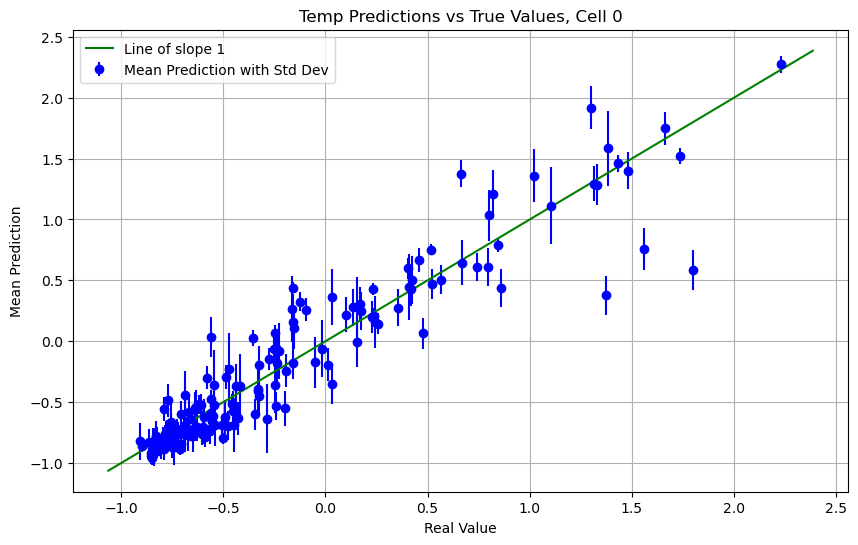

In [25]:
plot_cell(plot_values_cell_0, 0, 0)

## Plot all Cells

/tmp/ipykernel_660877/3957580471.py:23: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  plt.figure(figsize=(10, 6))


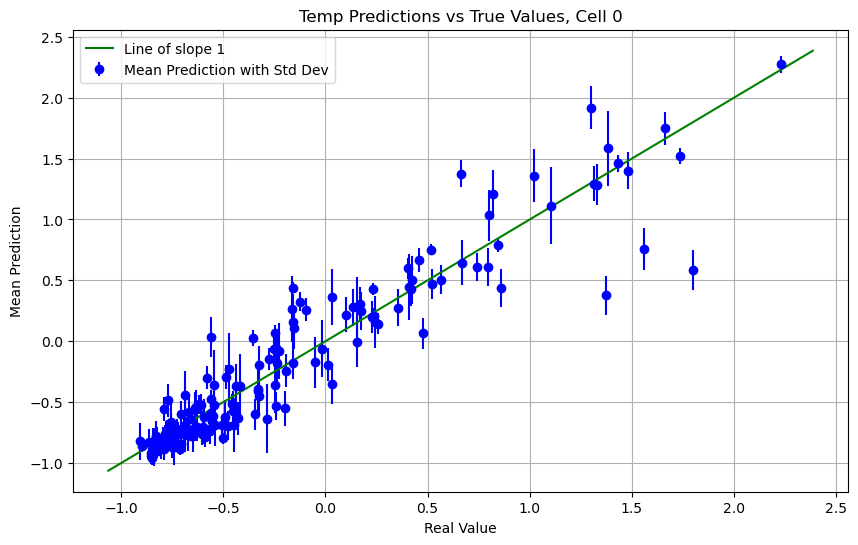

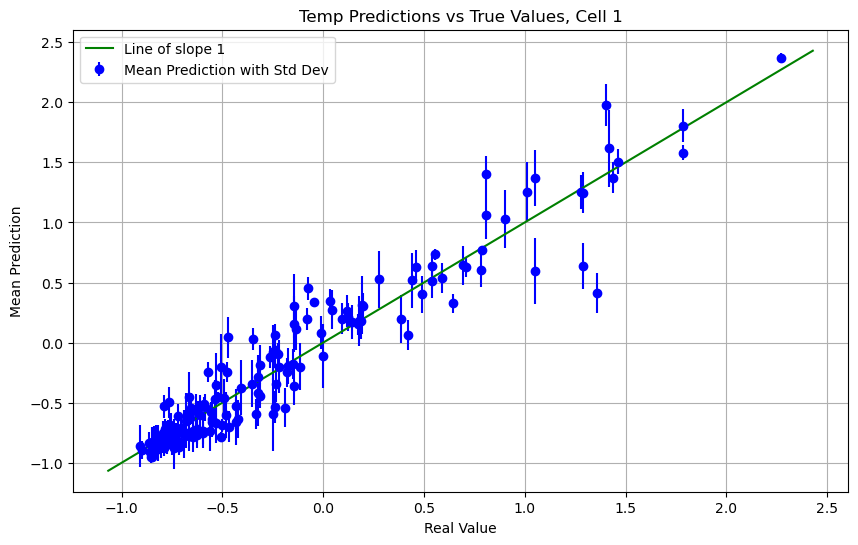

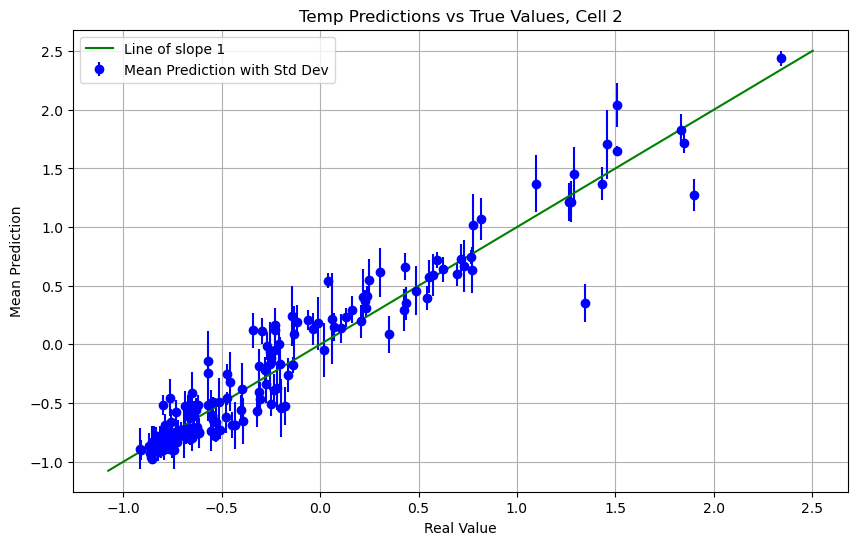

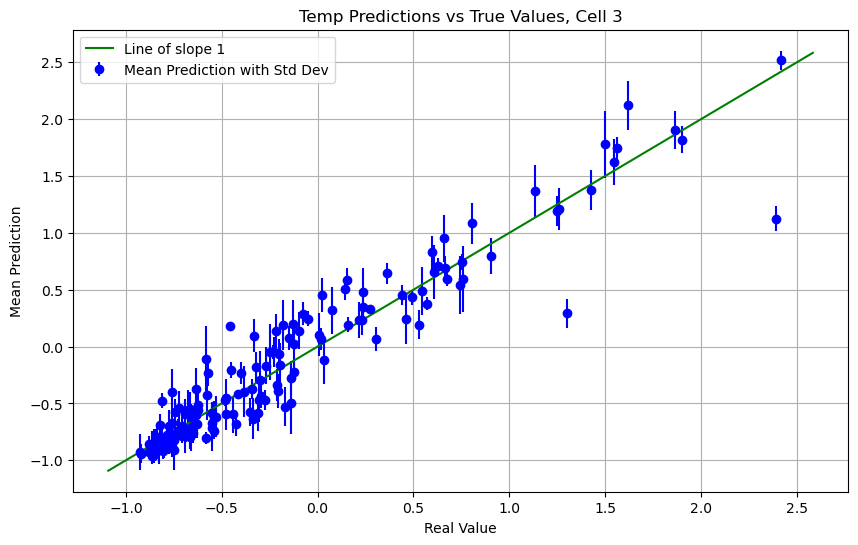

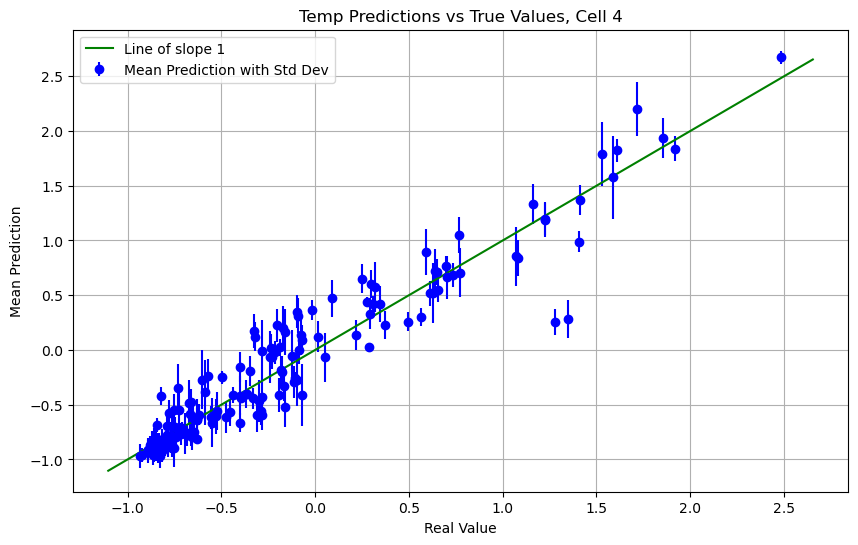

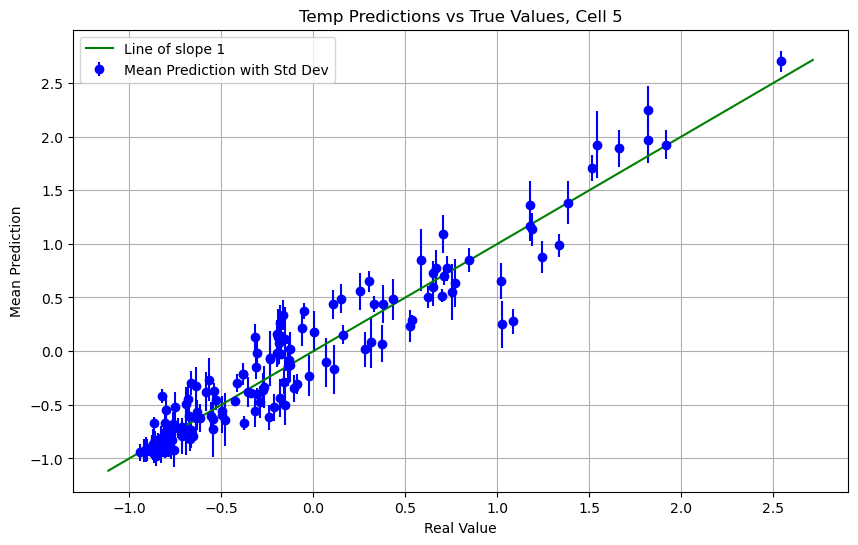

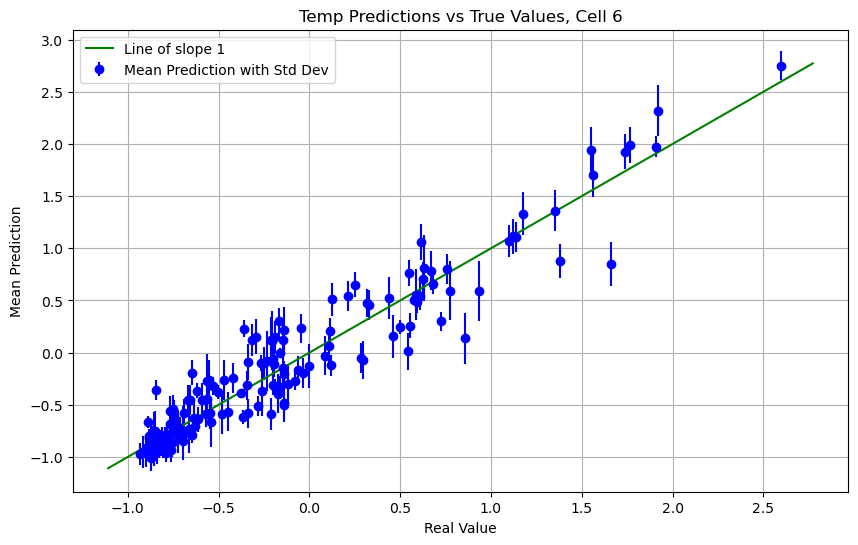

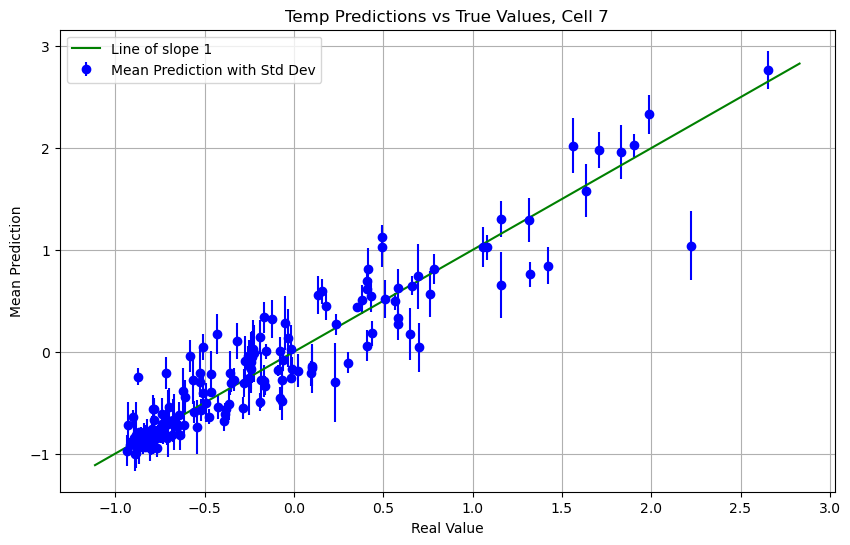

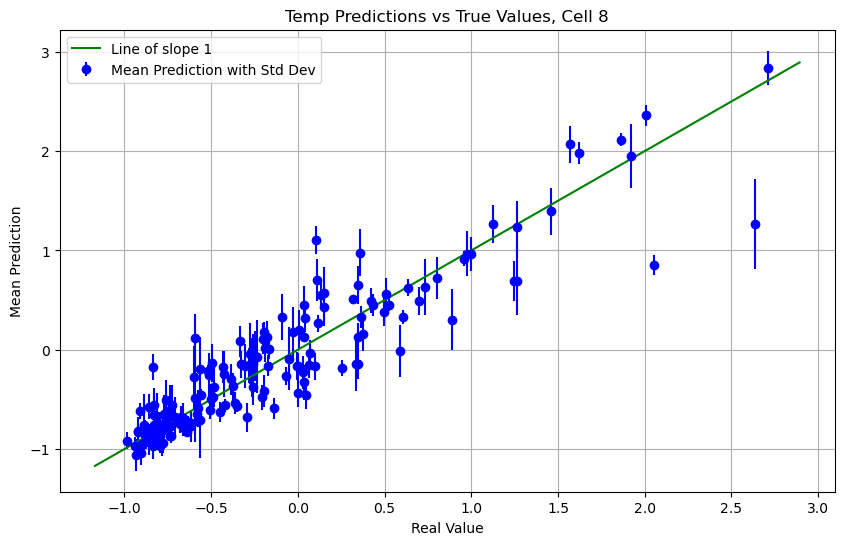

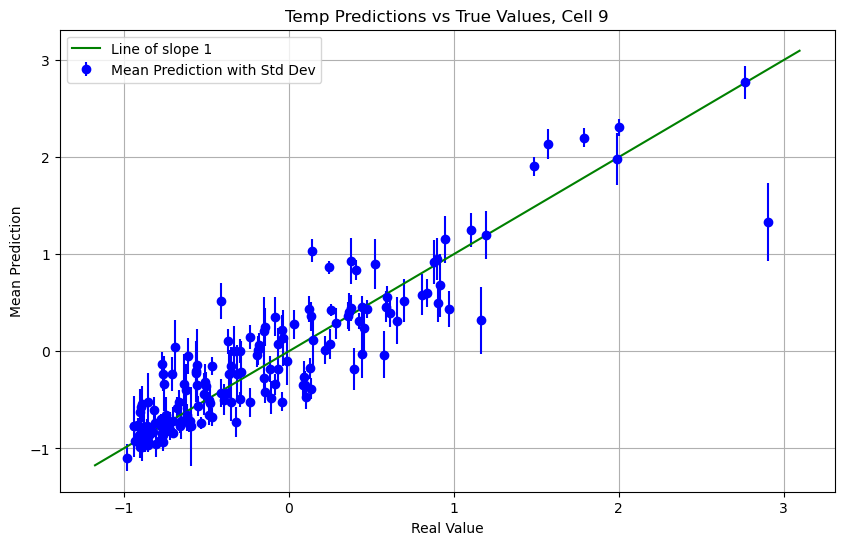

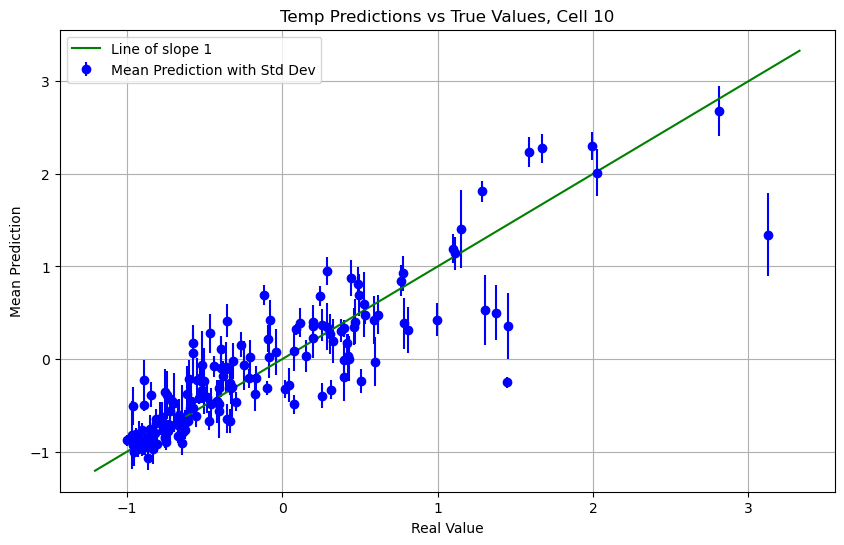

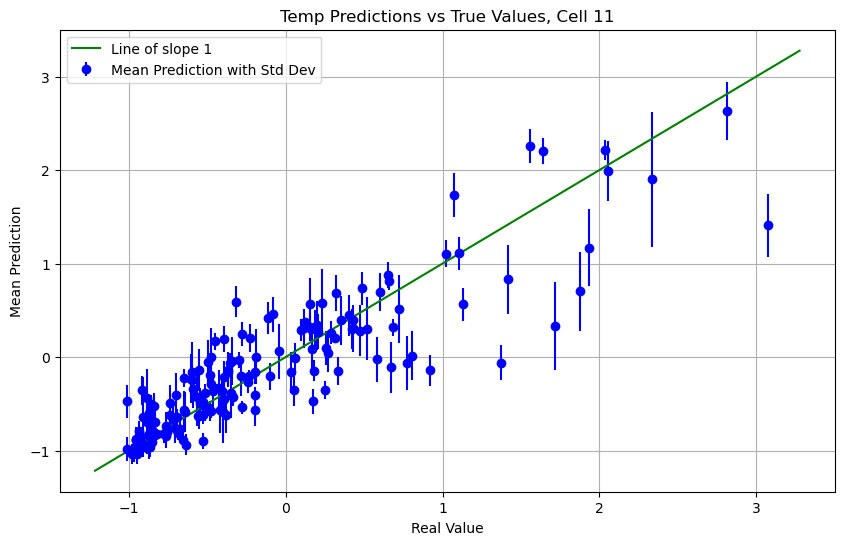

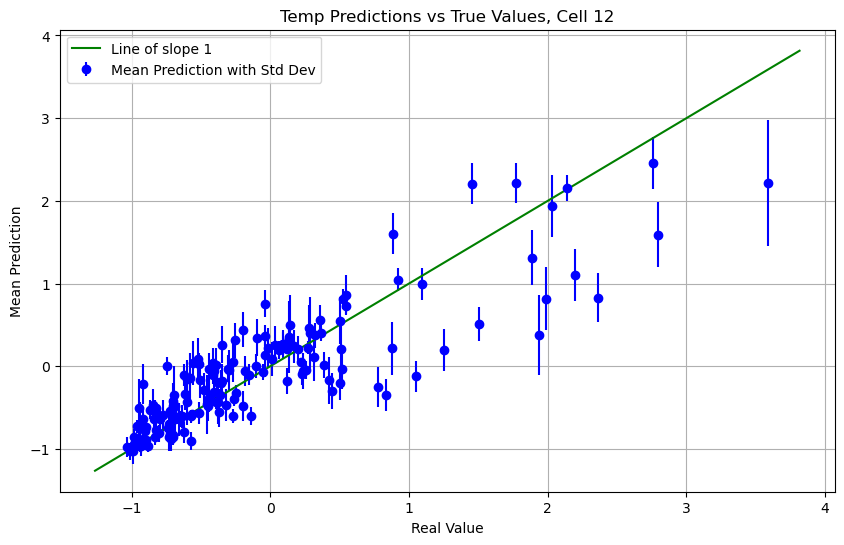

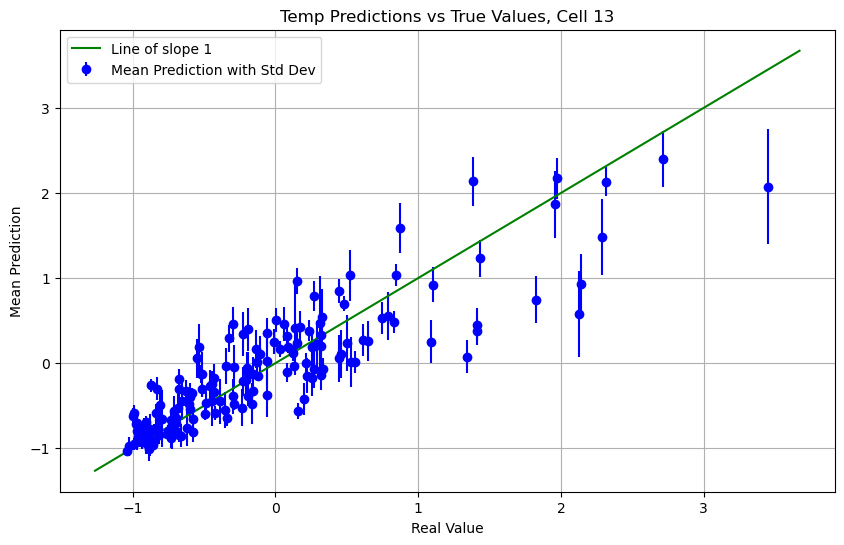

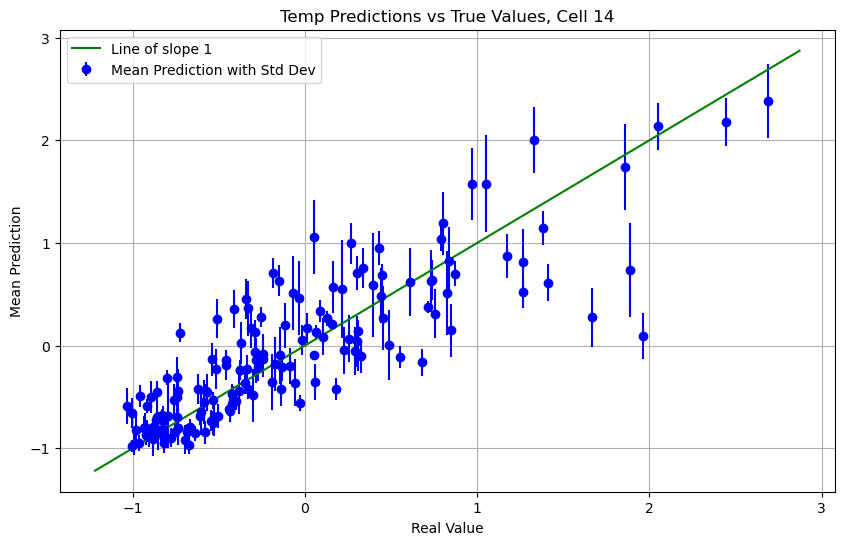

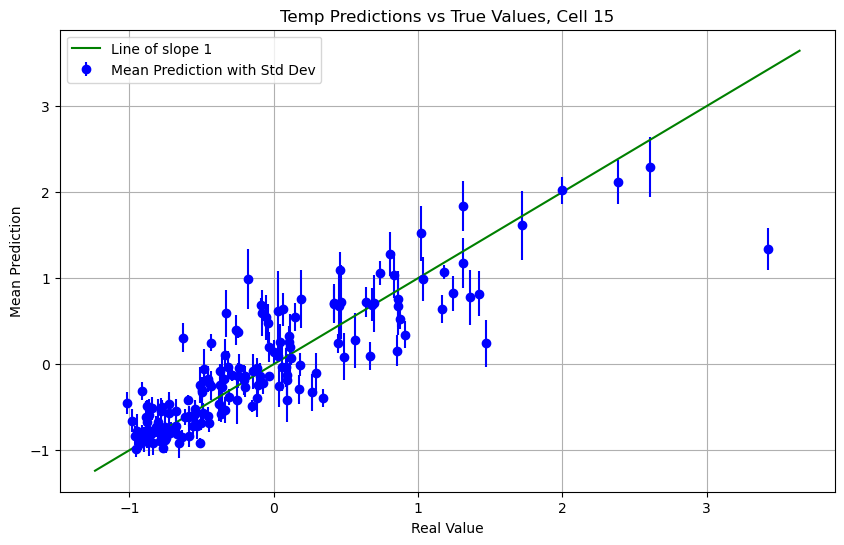

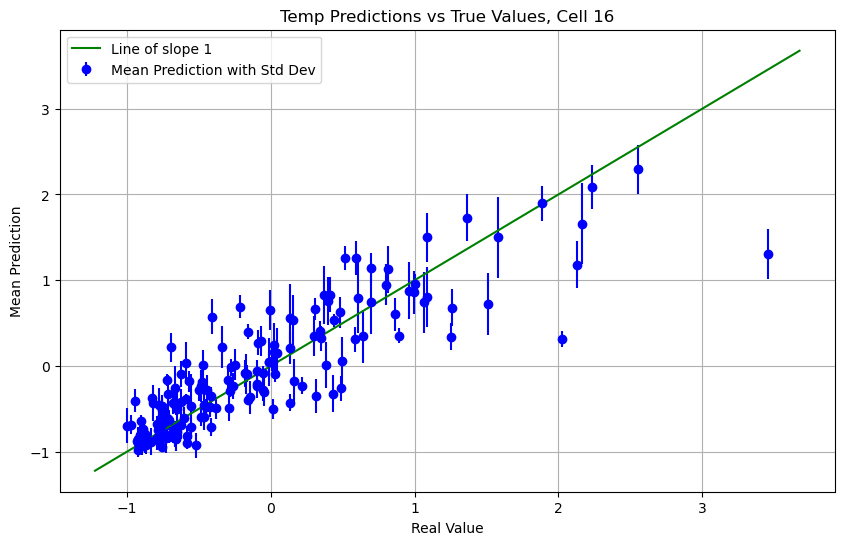

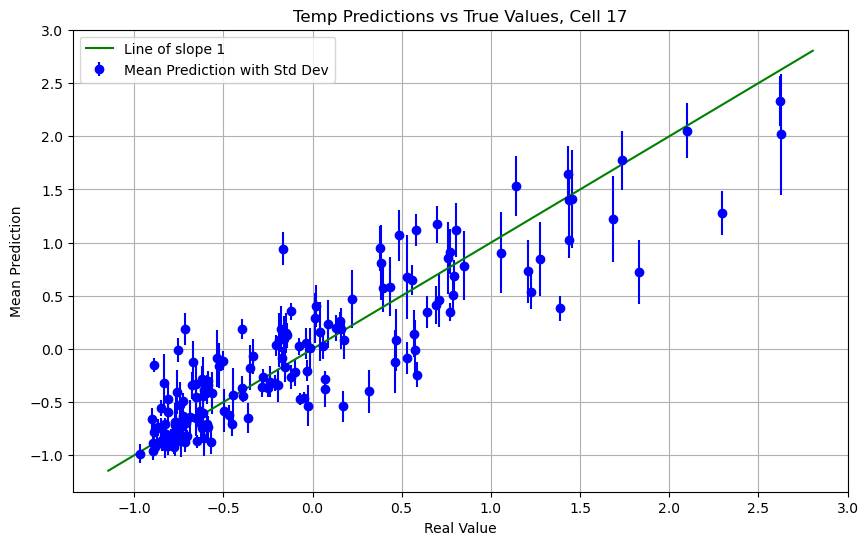

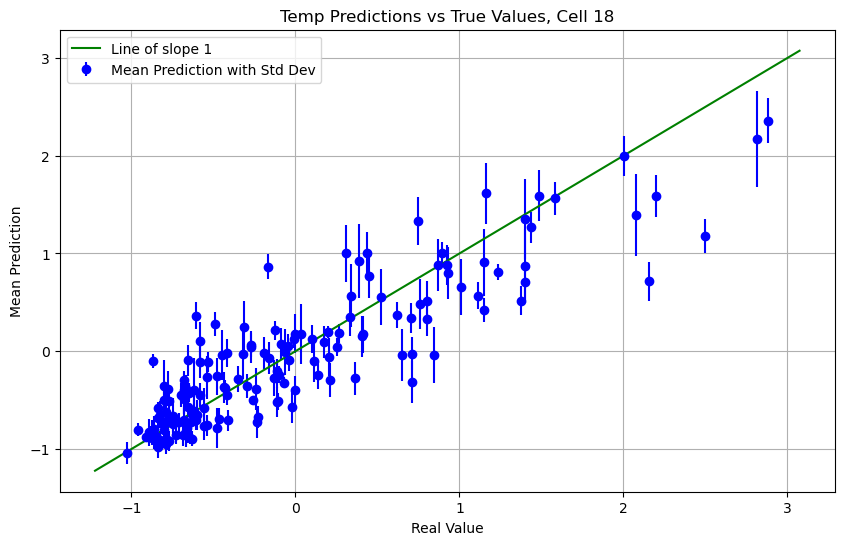

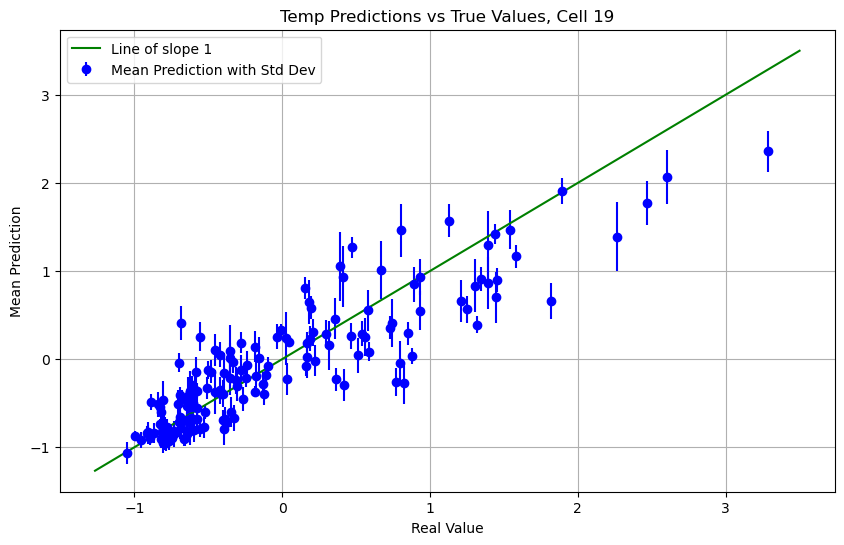

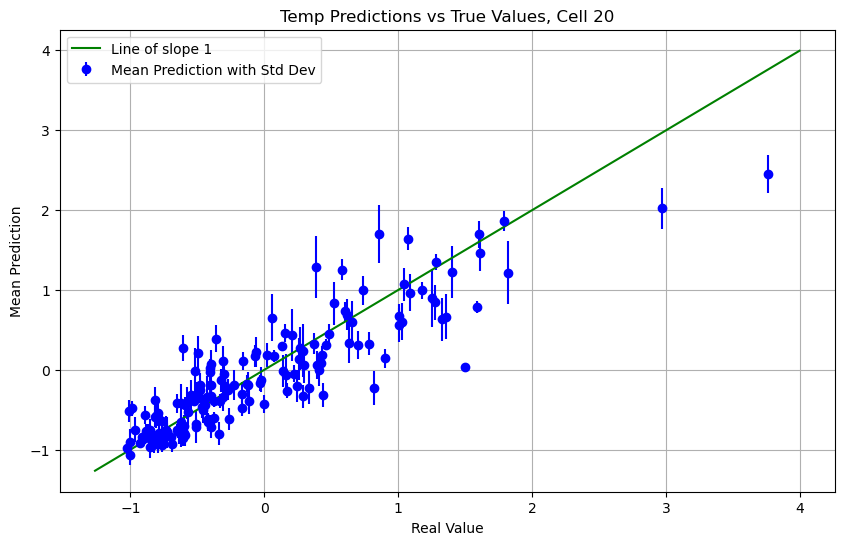

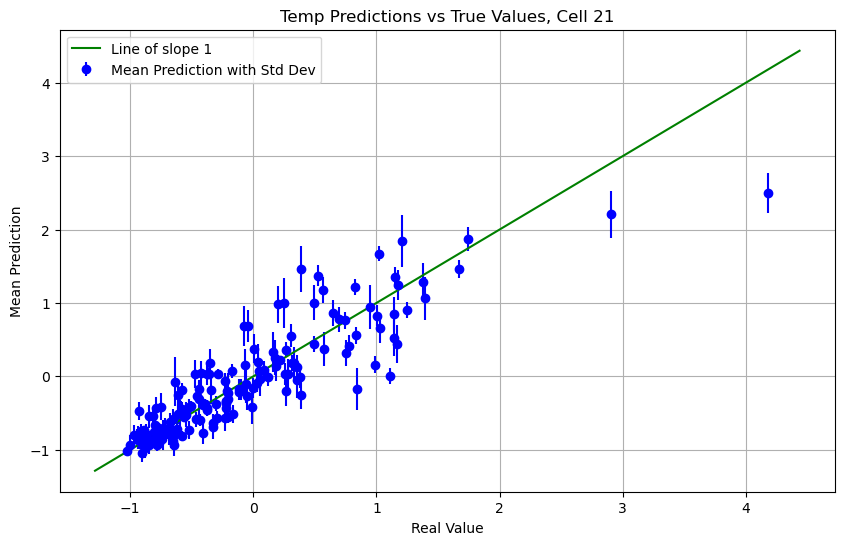

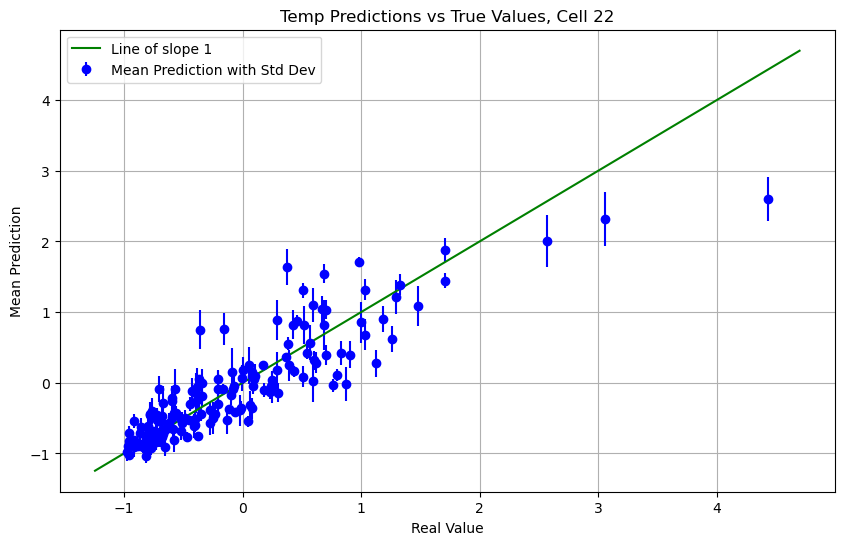

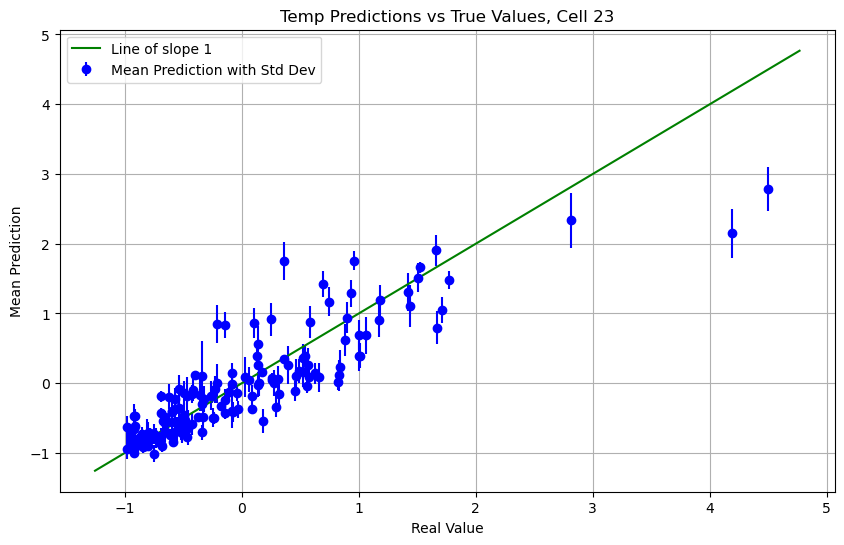

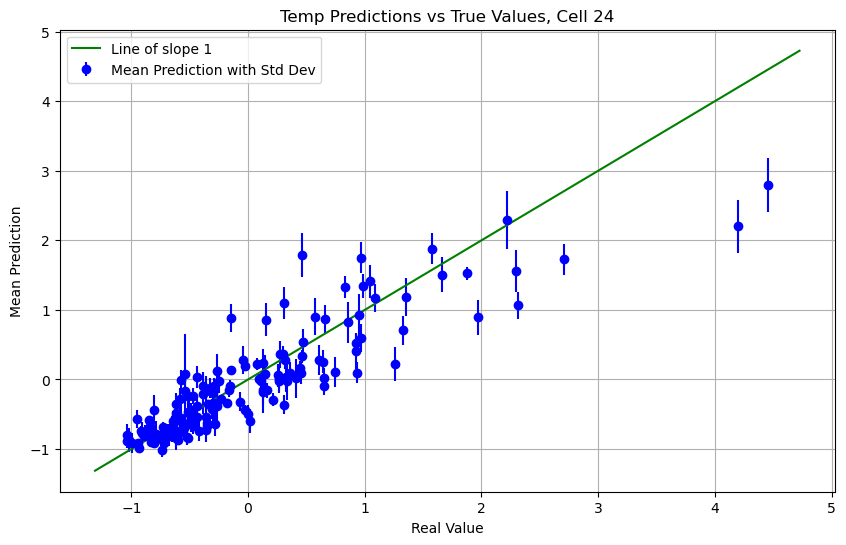

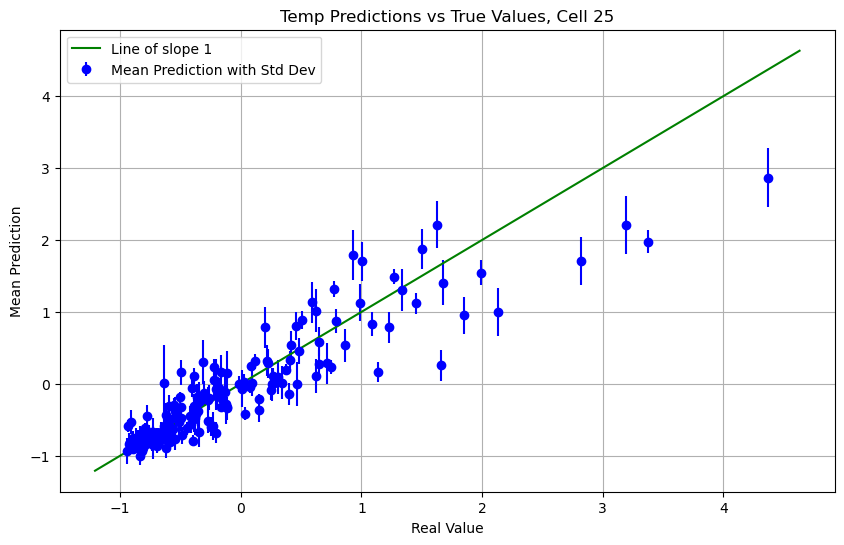

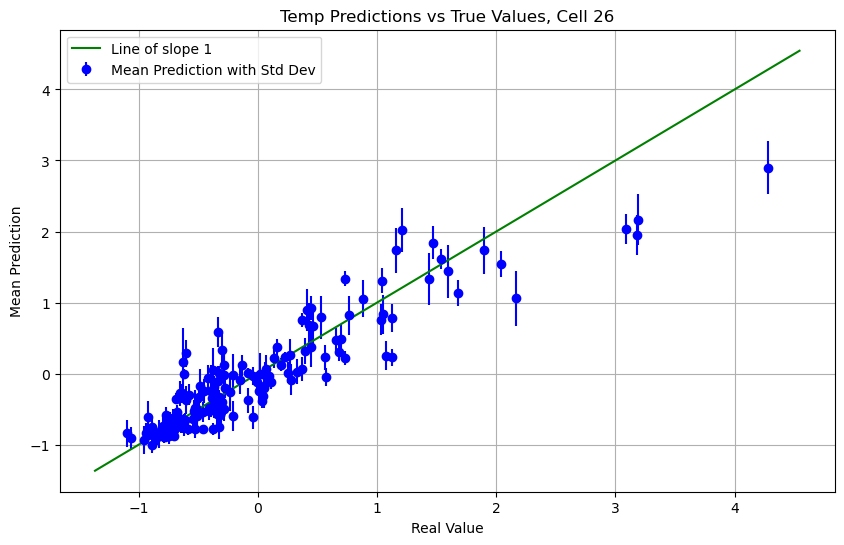

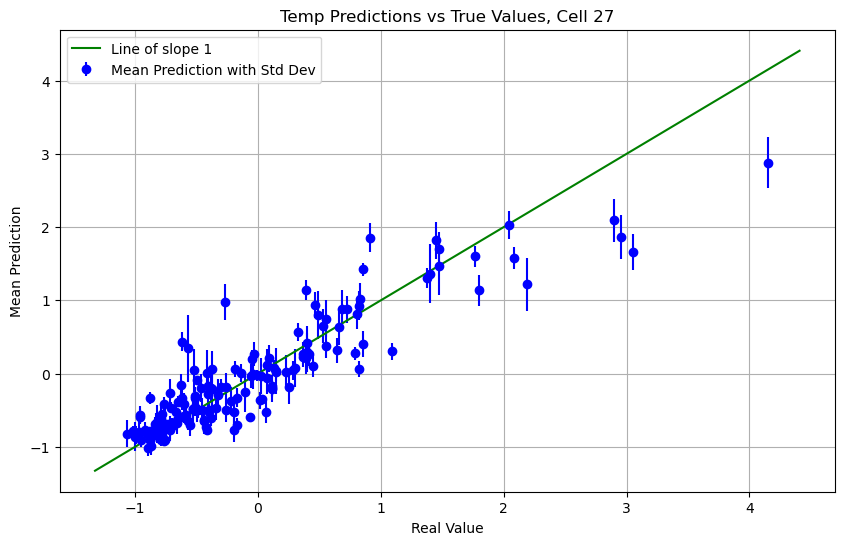

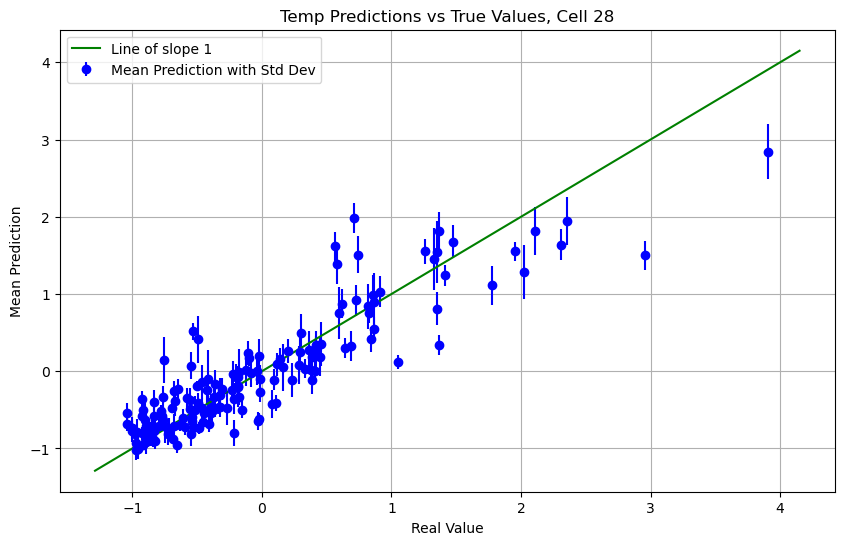

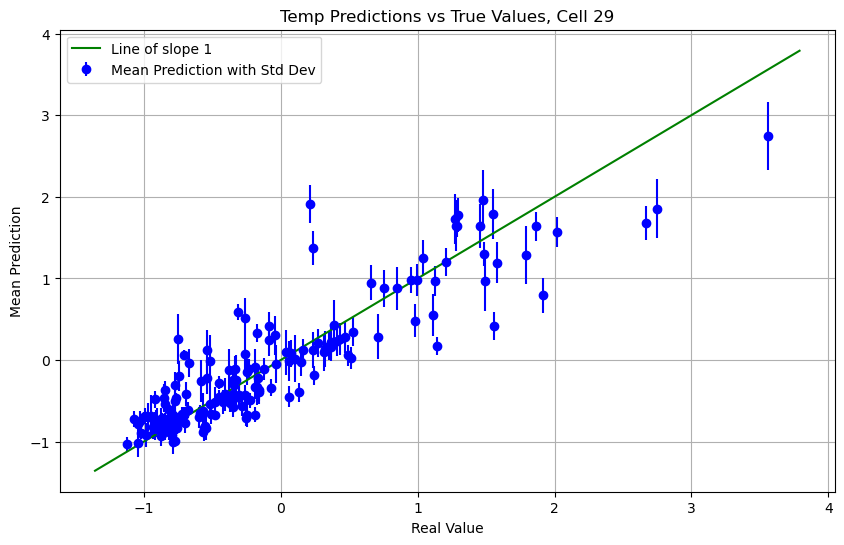

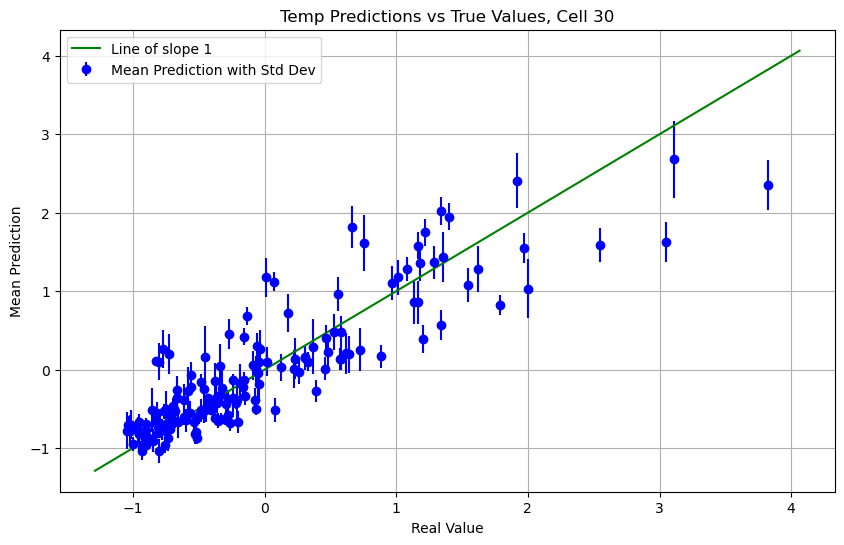

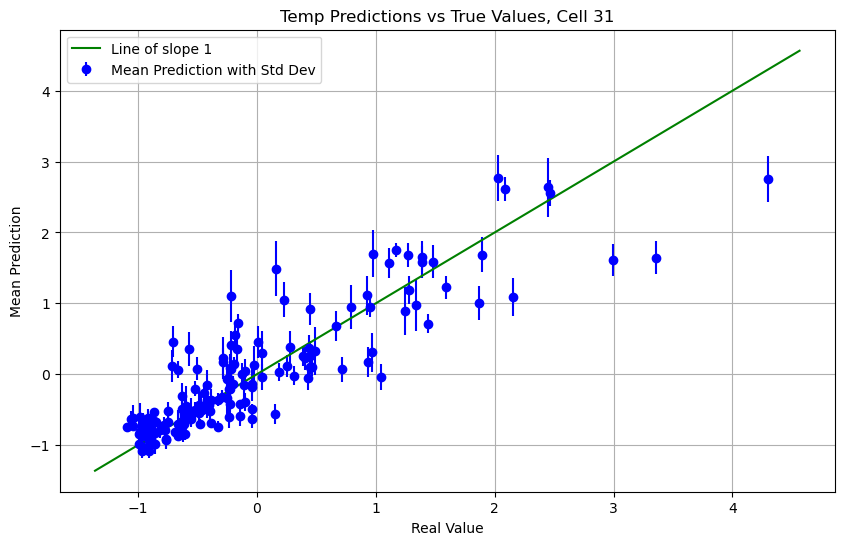

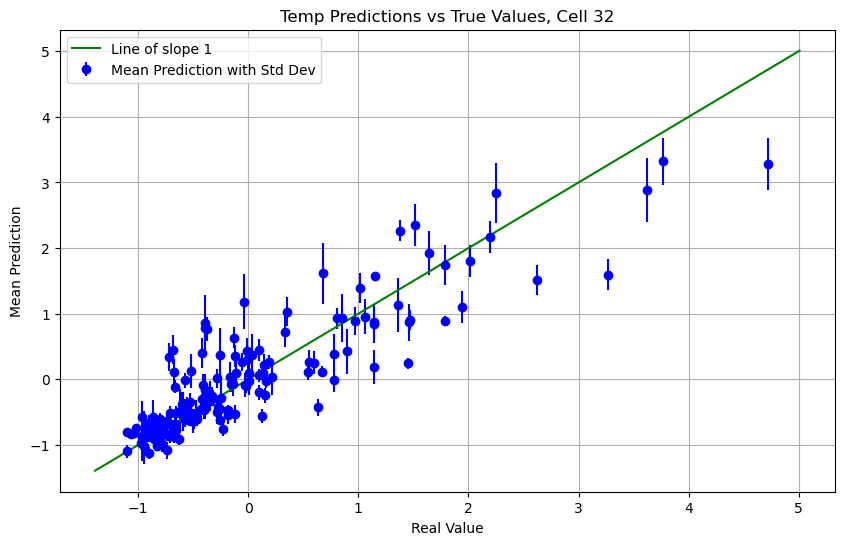

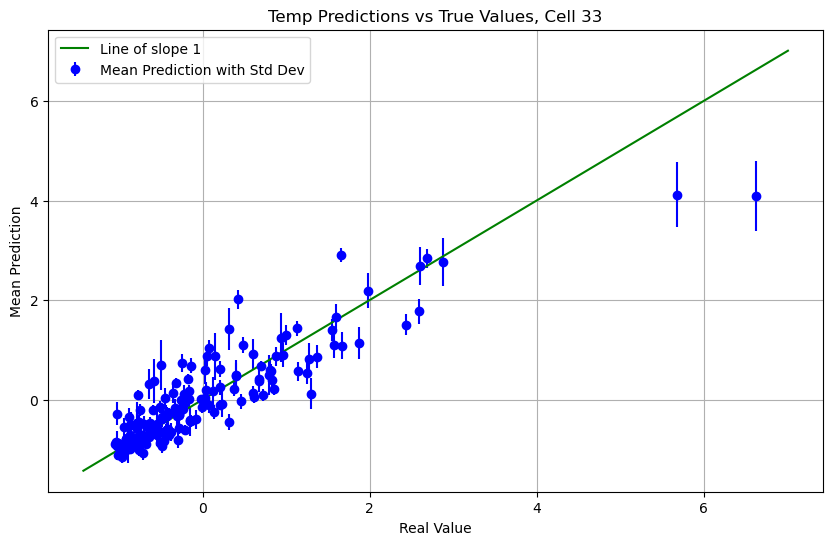

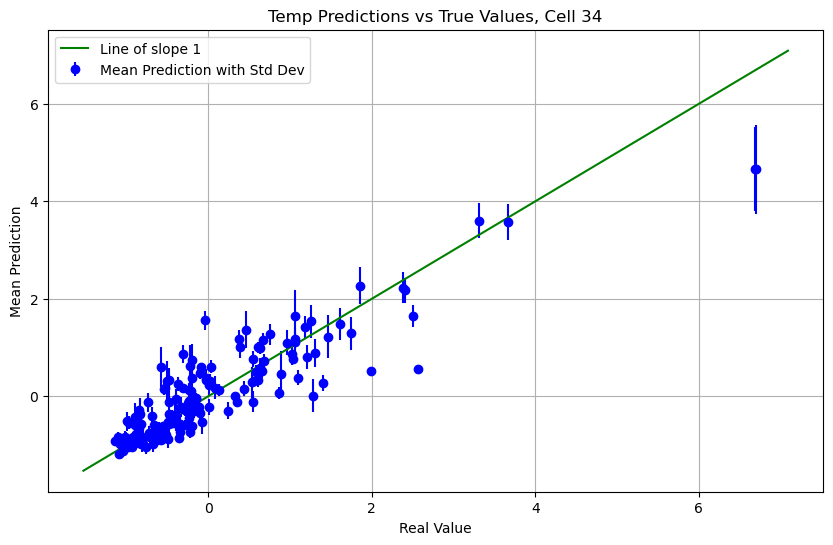

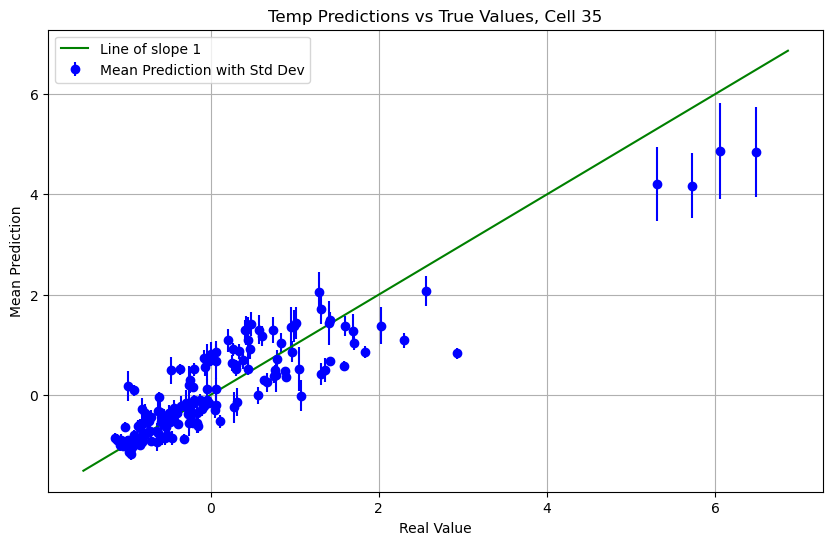

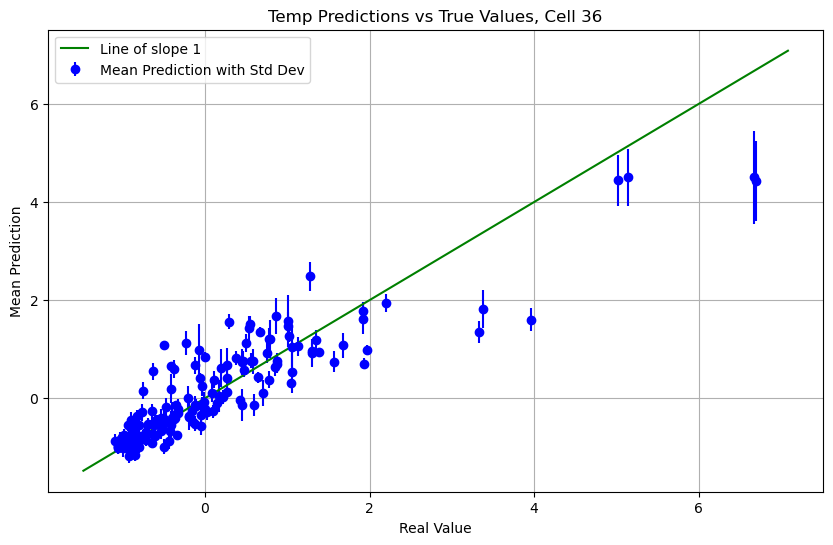

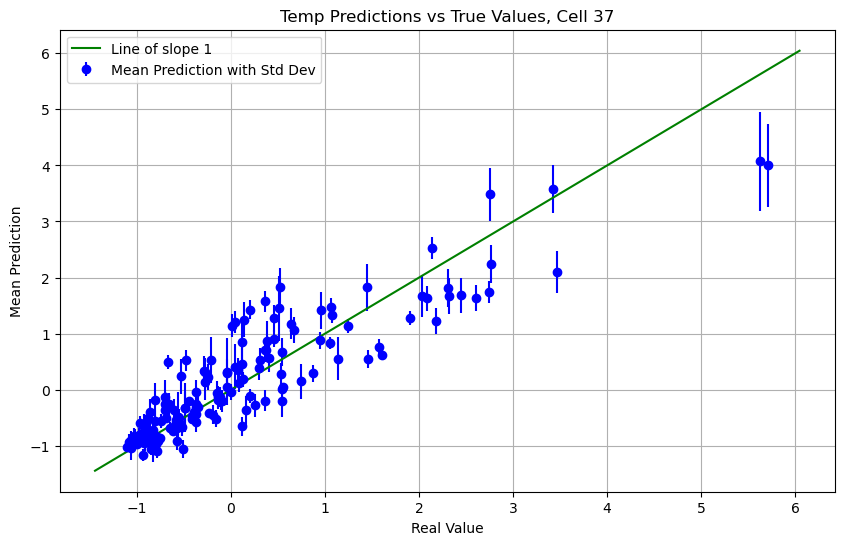

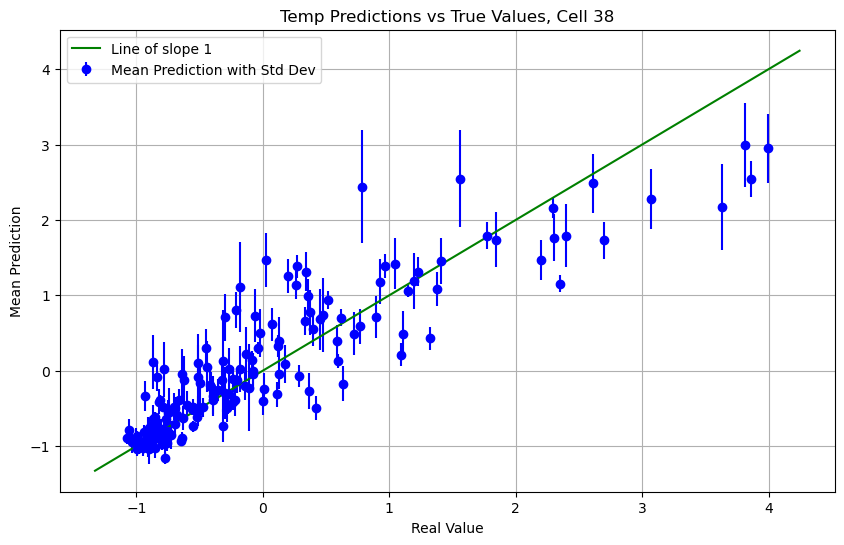

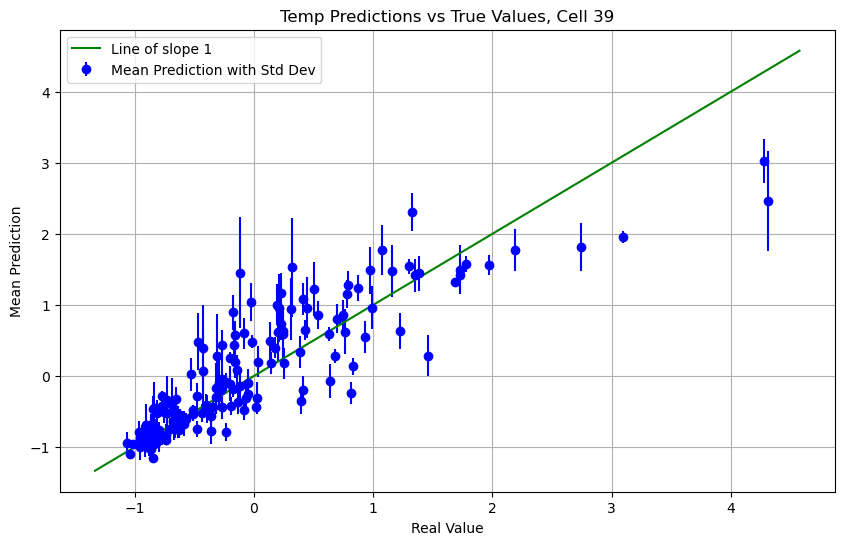

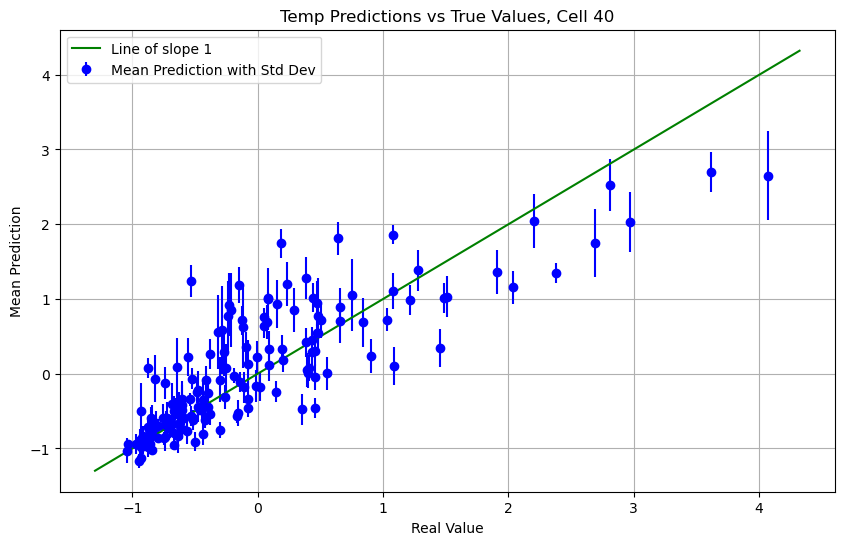

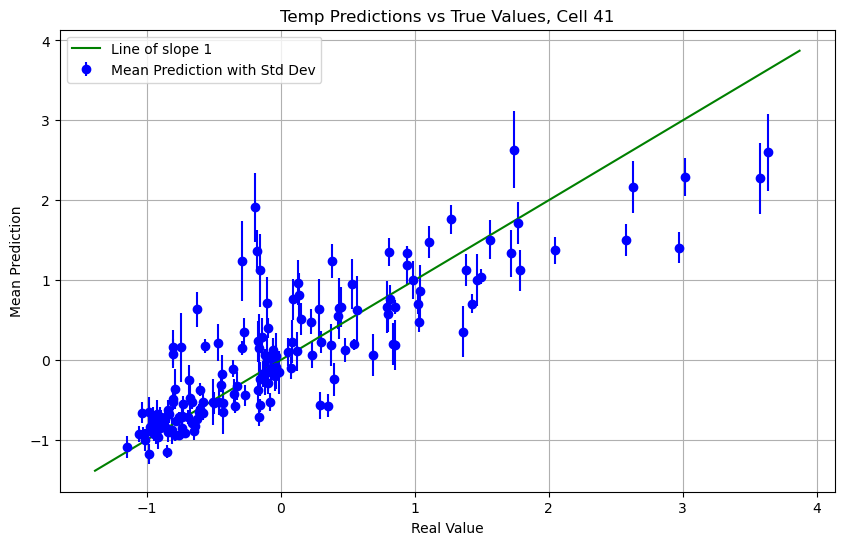

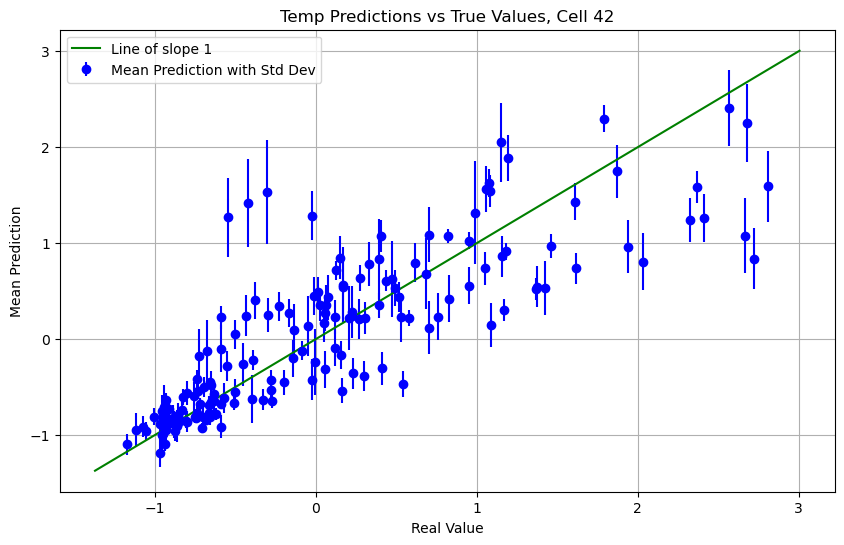

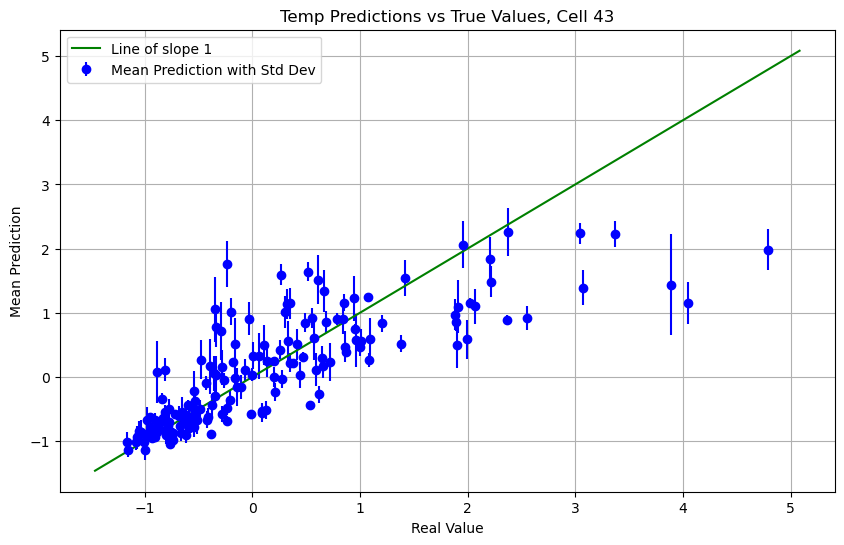

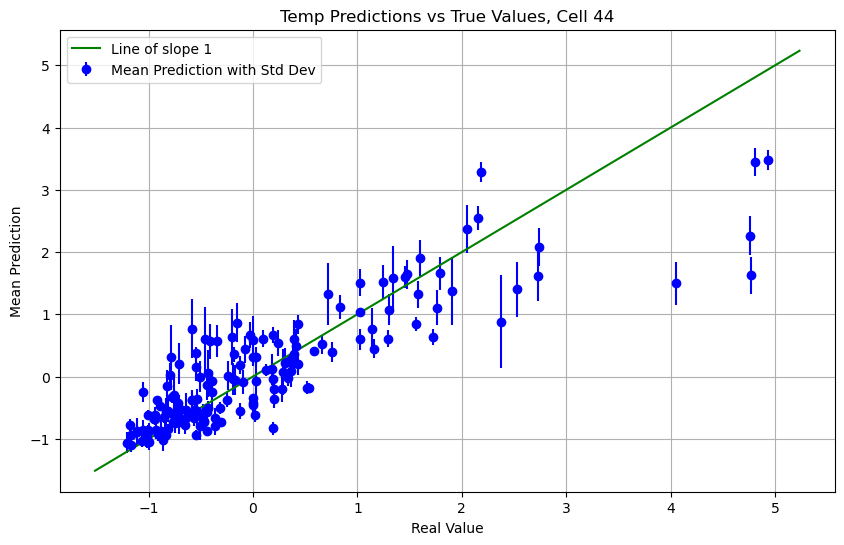

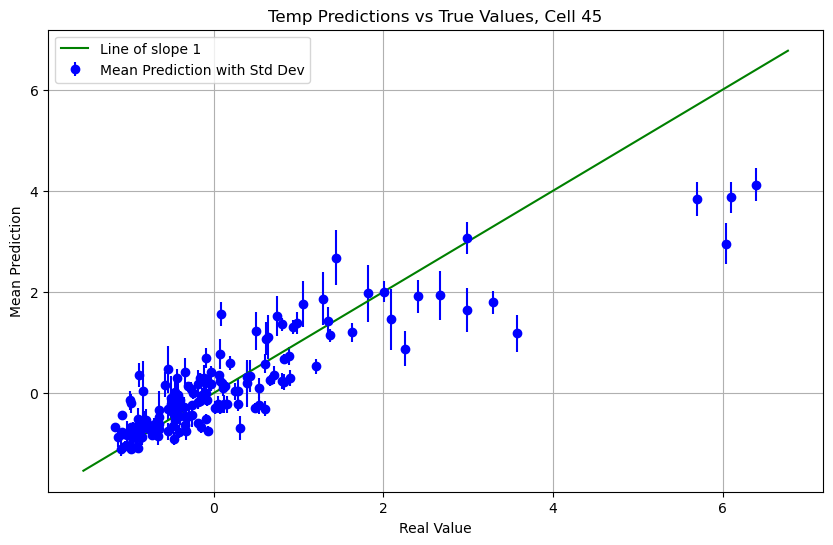

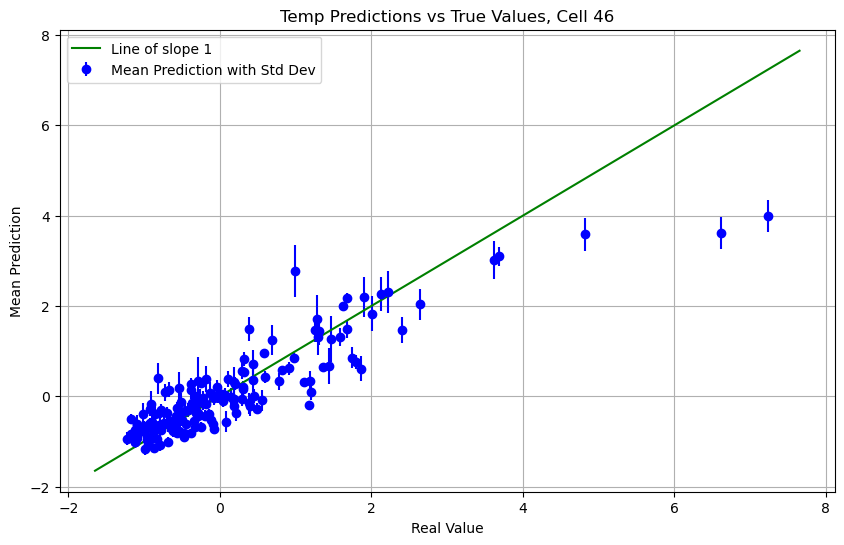

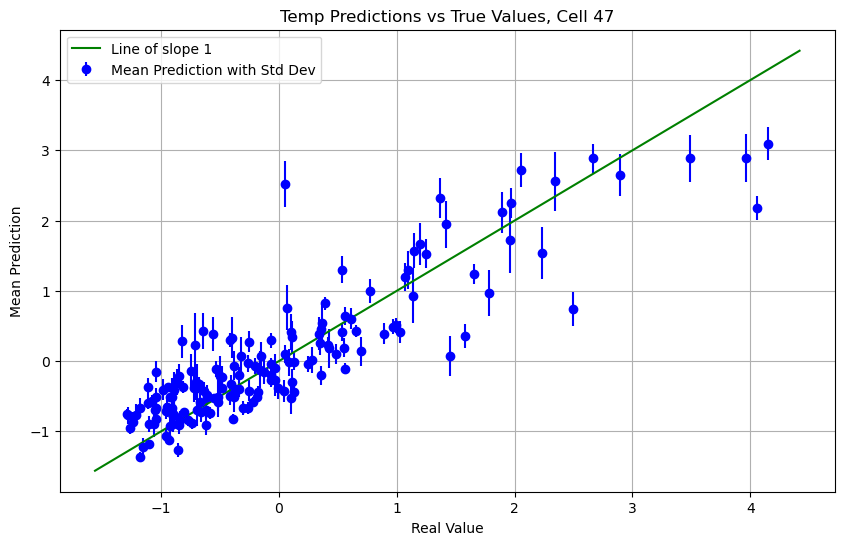

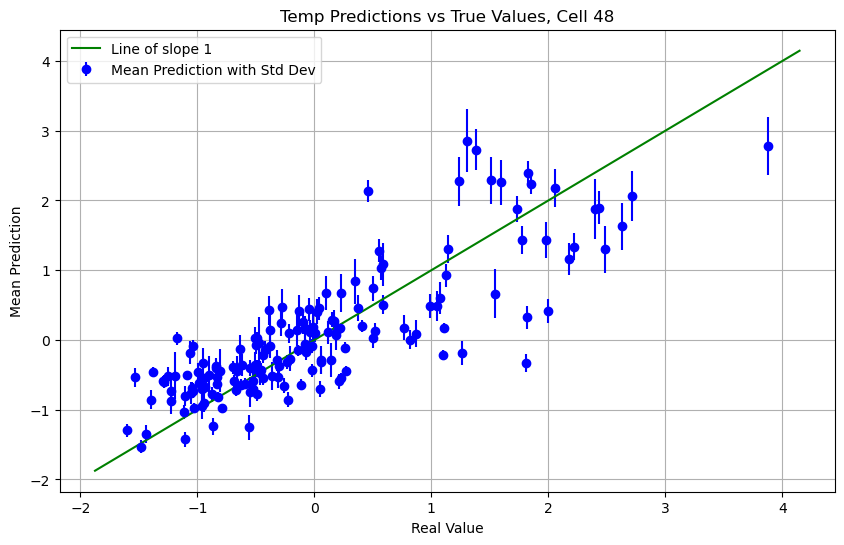

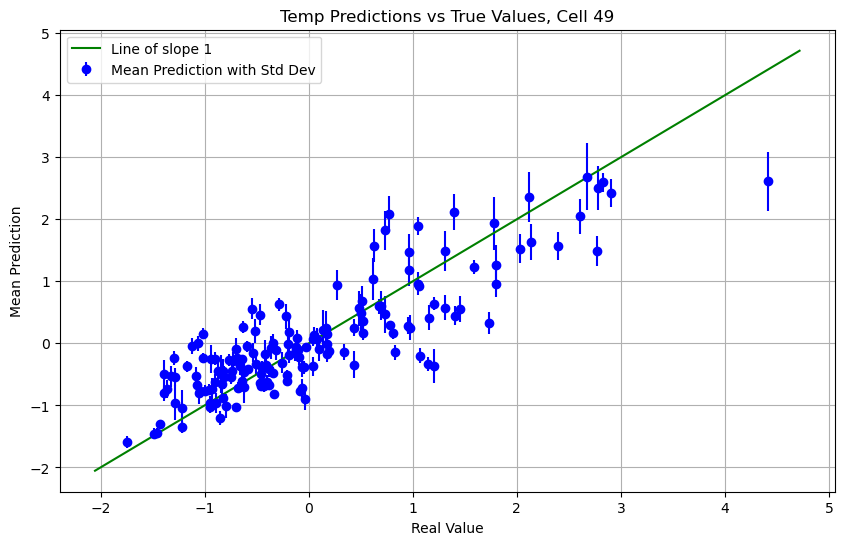

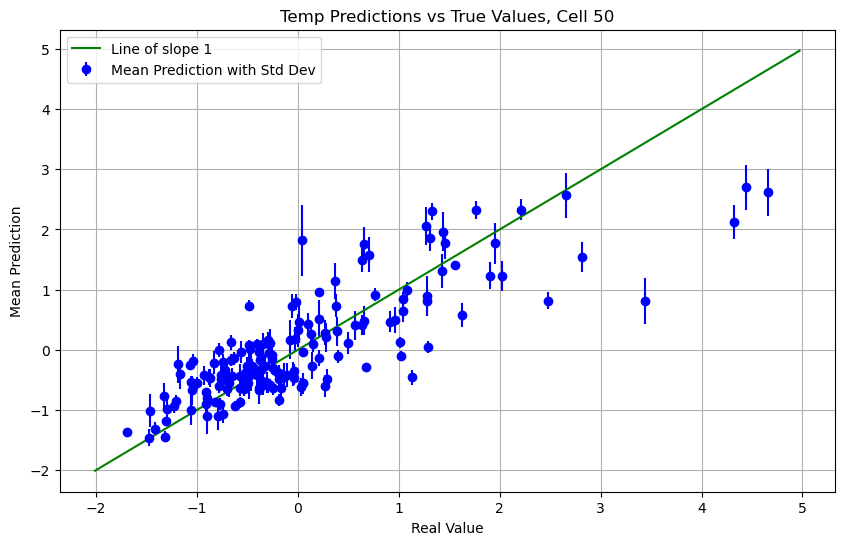

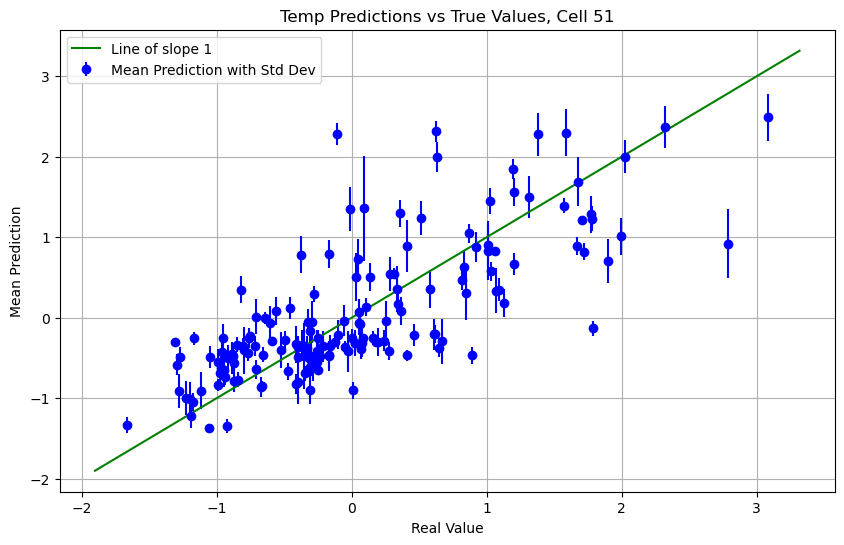

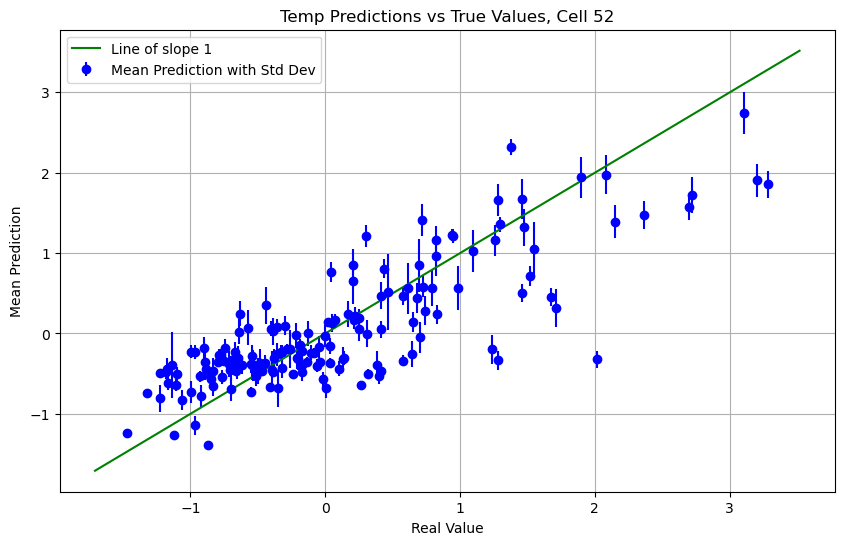

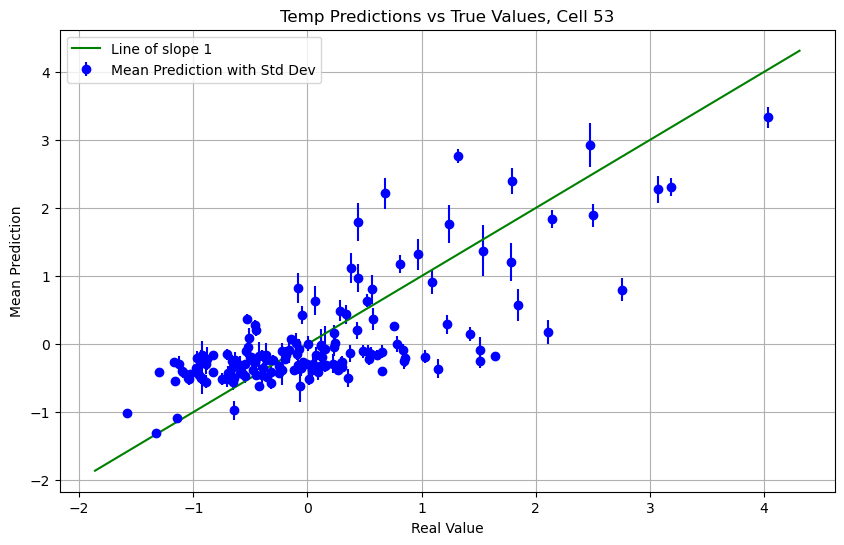

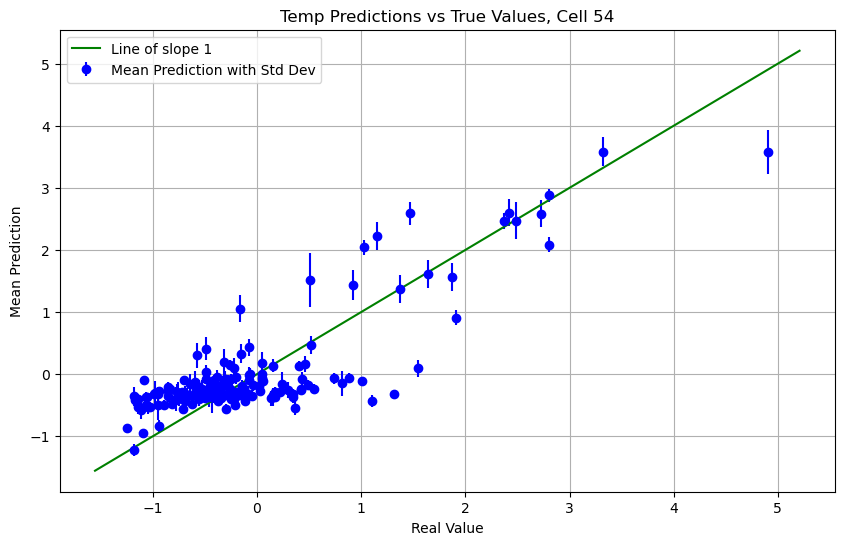

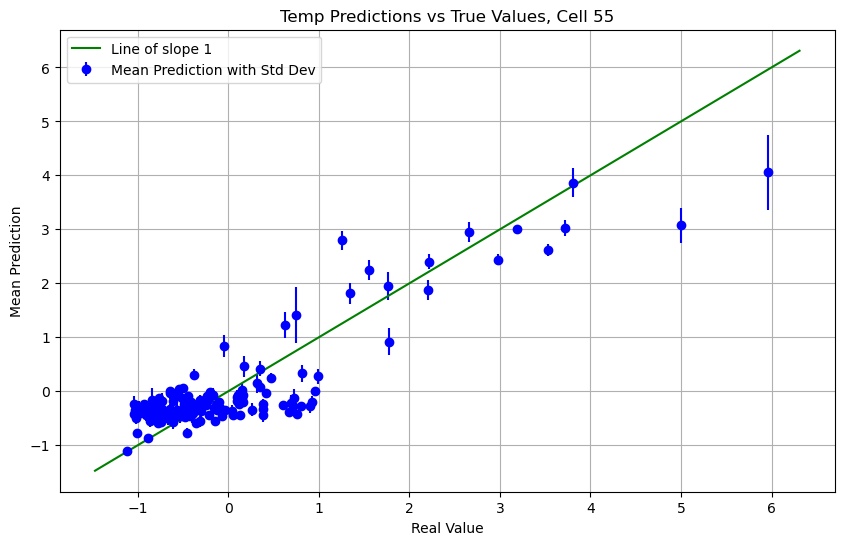

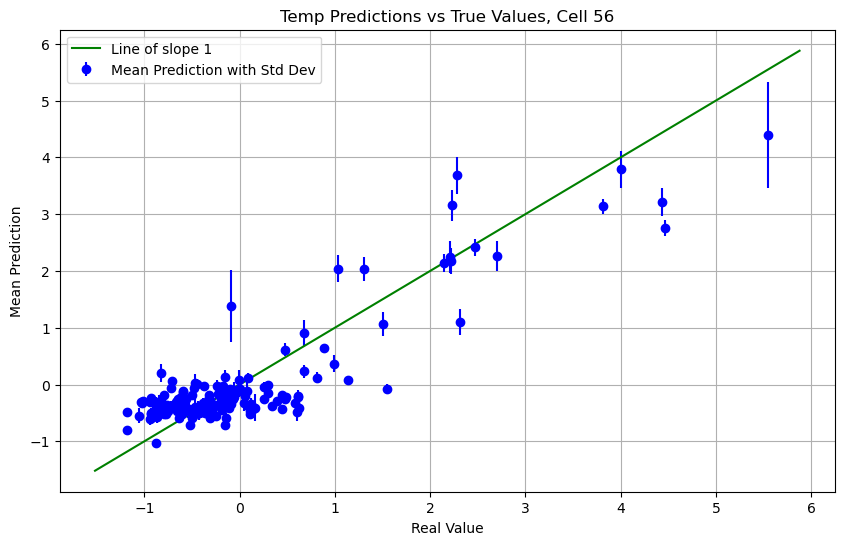

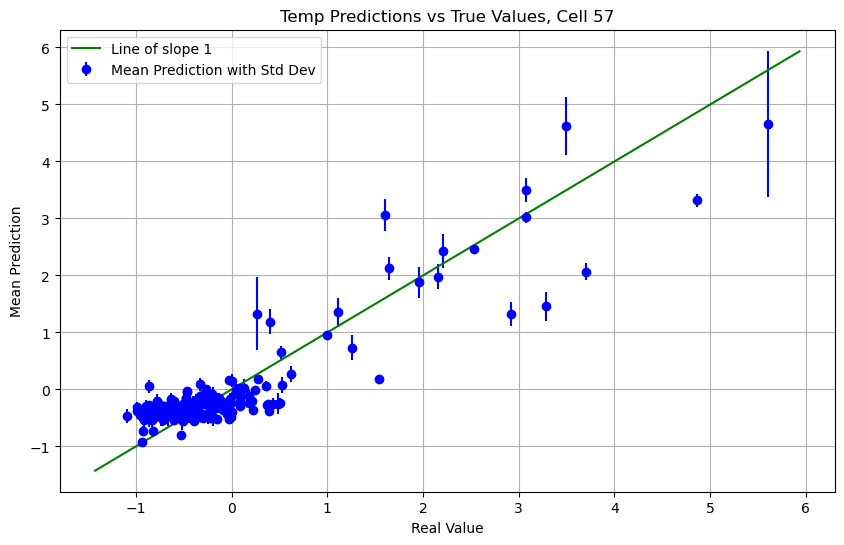

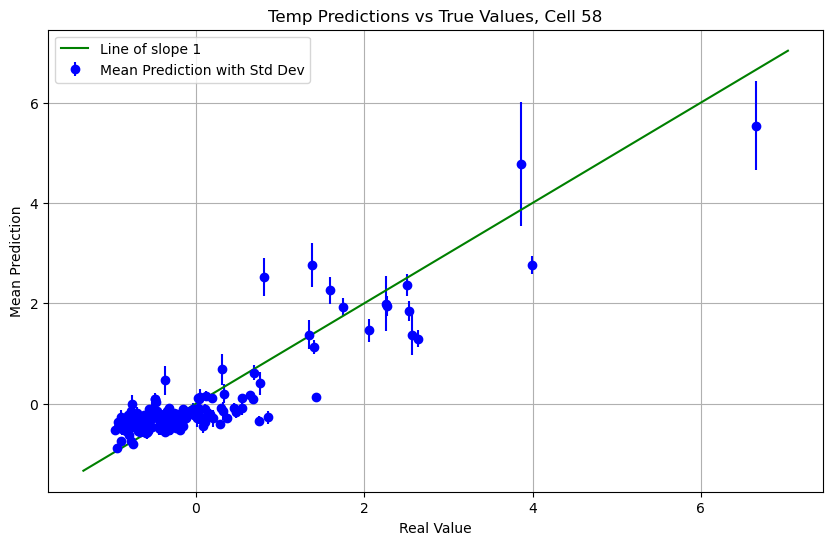

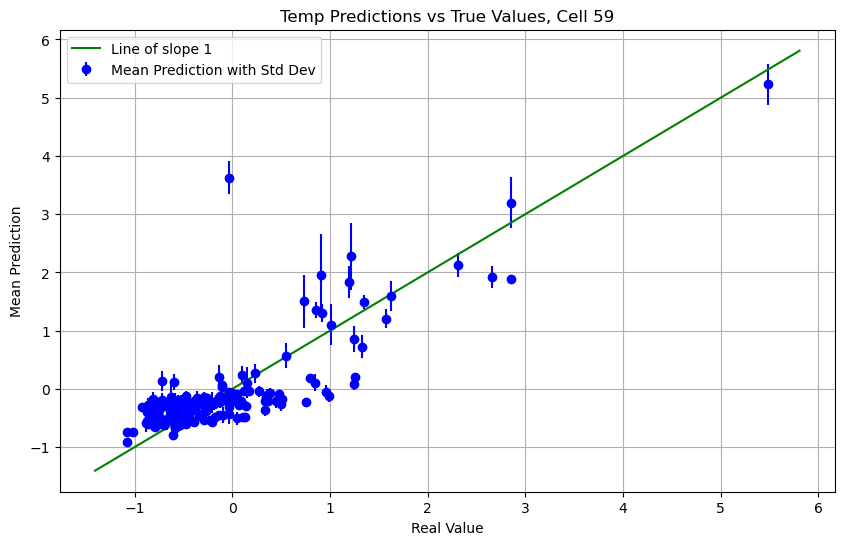

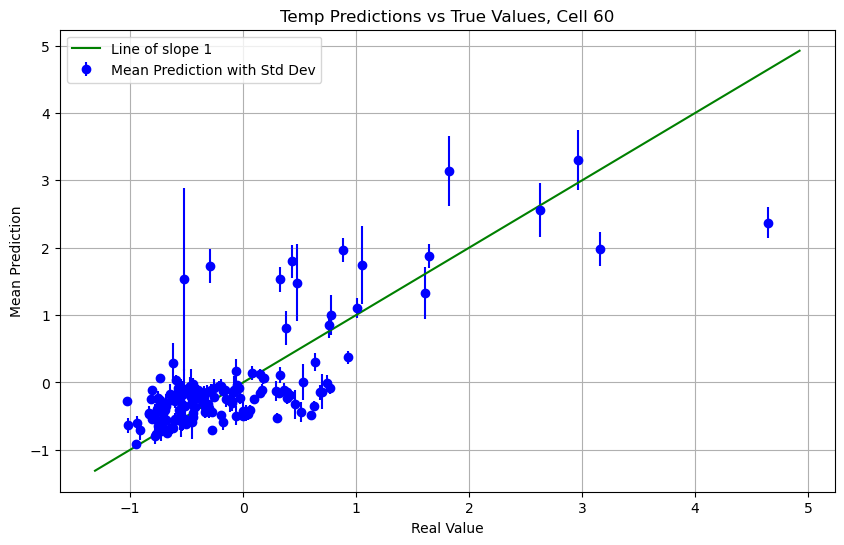

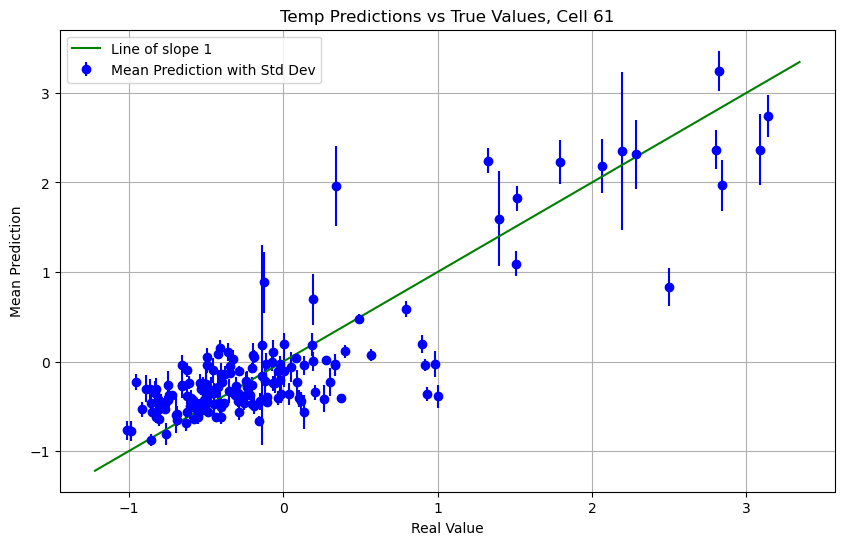

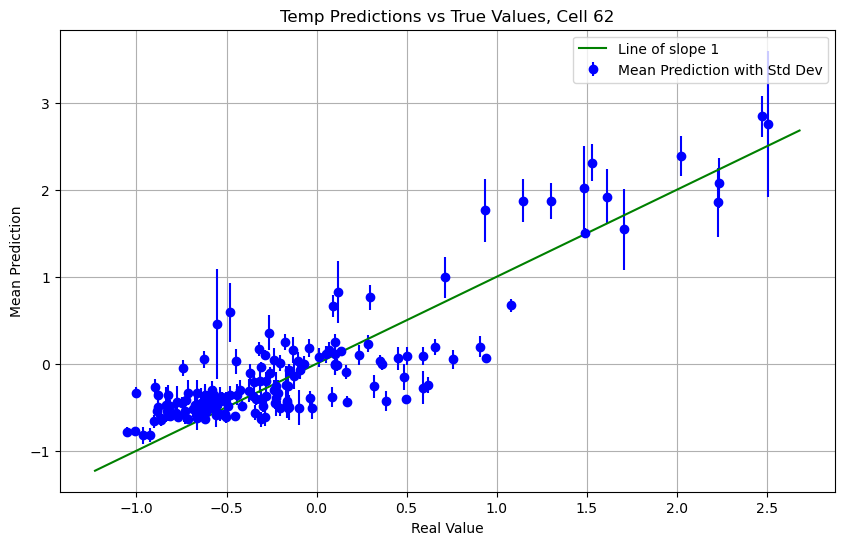

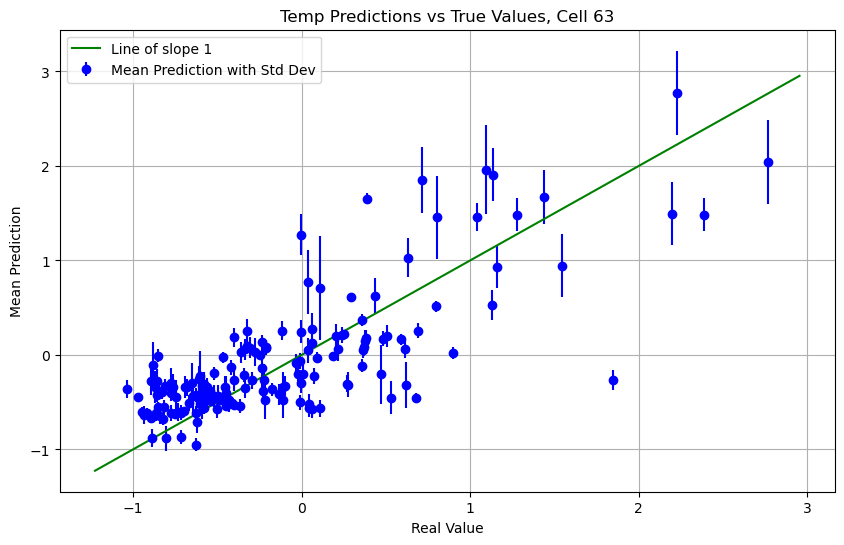

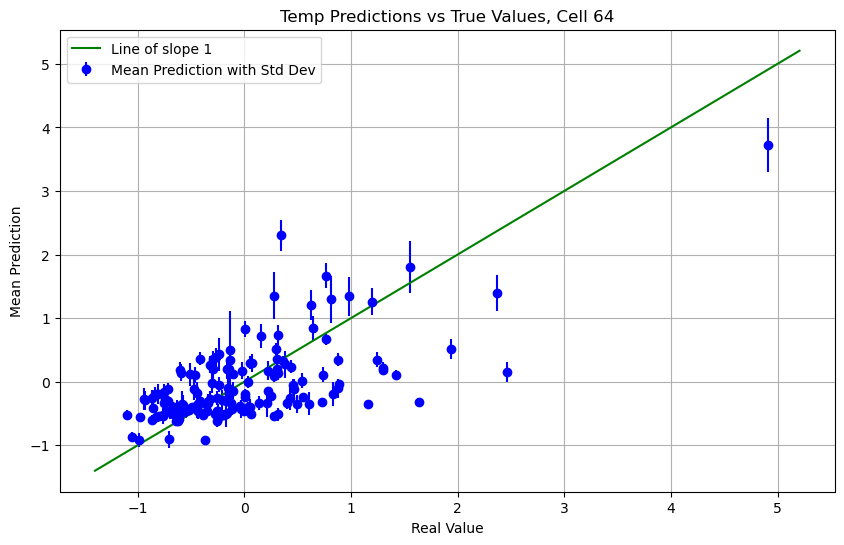

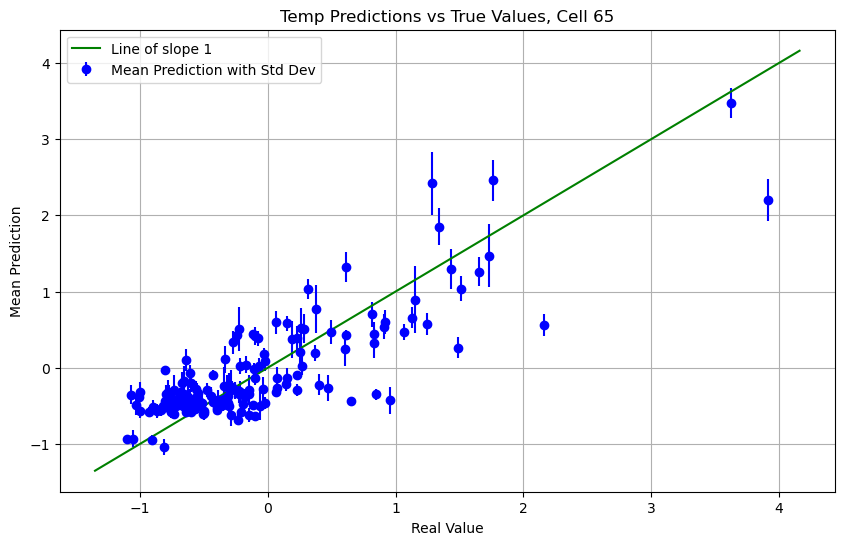

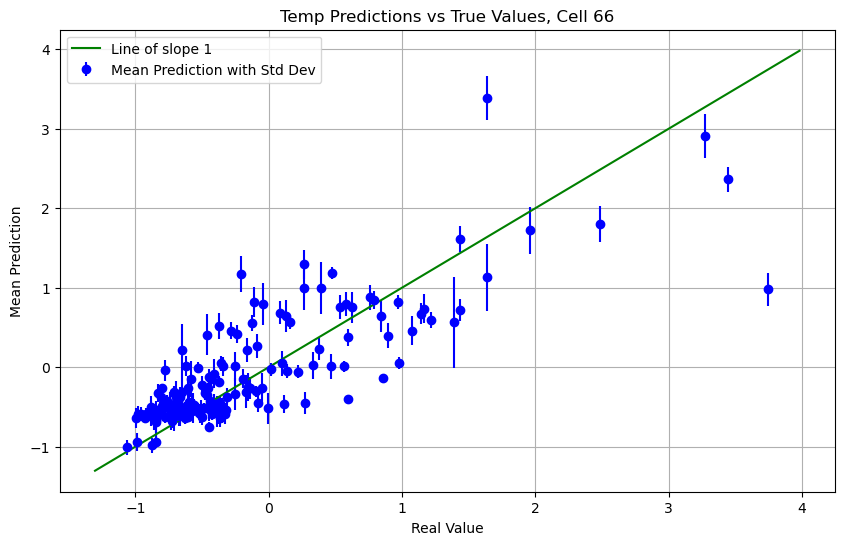

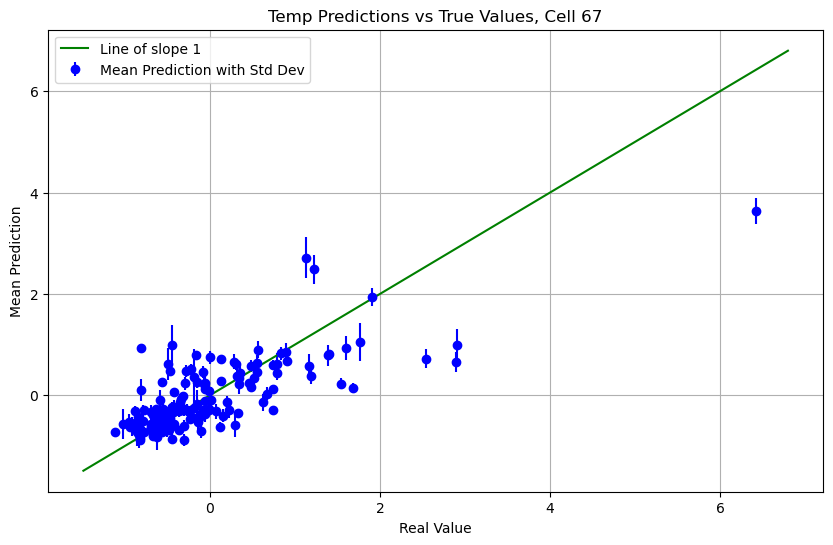

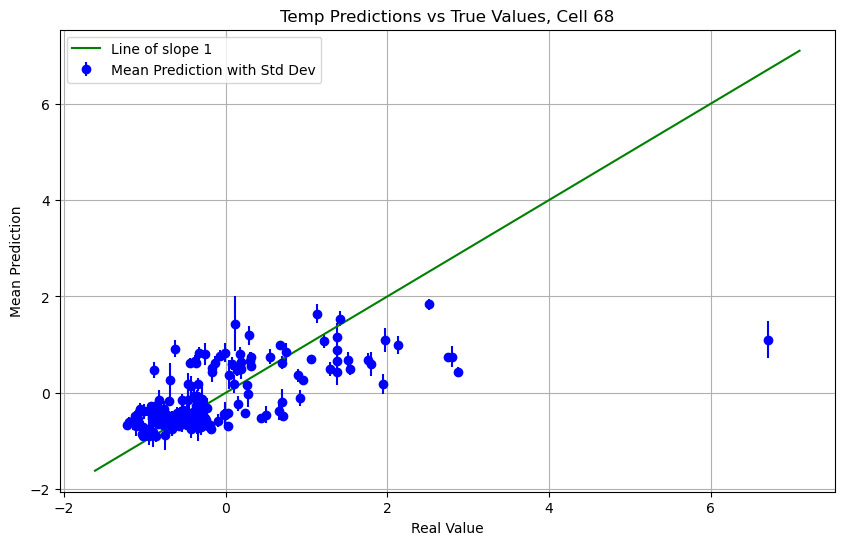

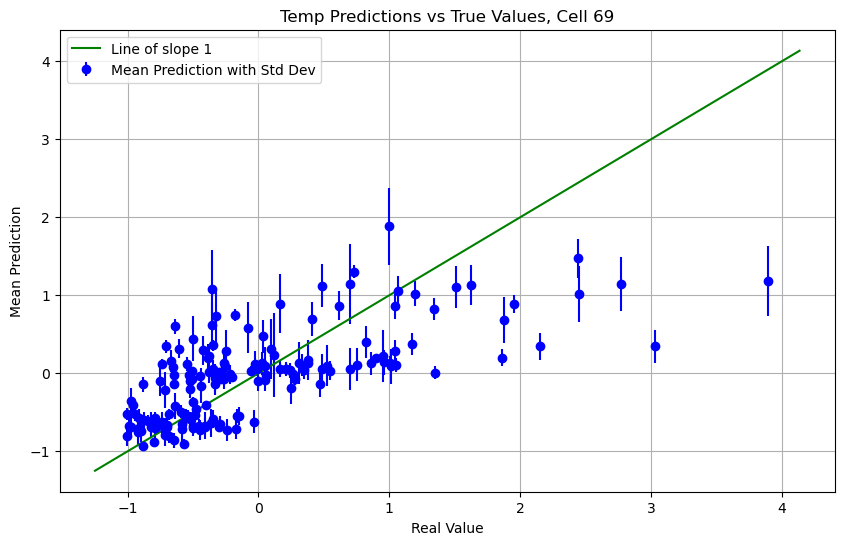

In [27]:
for i in range(70):
    plot_values = {}
    for k,v in model_preds.items():
        plot_values[k] = (slice_column(v[0], i), slice_column(v[1], i))
    plot_cell(plot_values, i, 0)


/tmp/ipykernel_660877/3957580471.py:23: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  plt.figure(figsize=(10, 6))


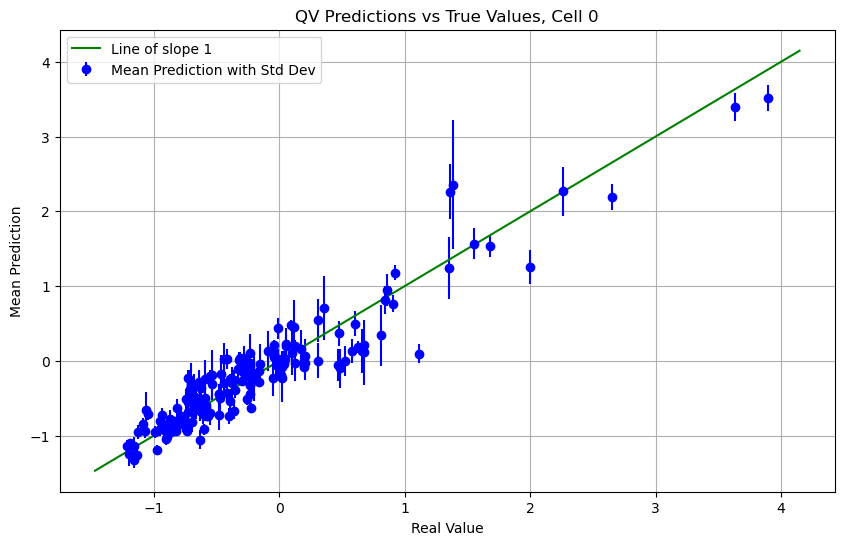

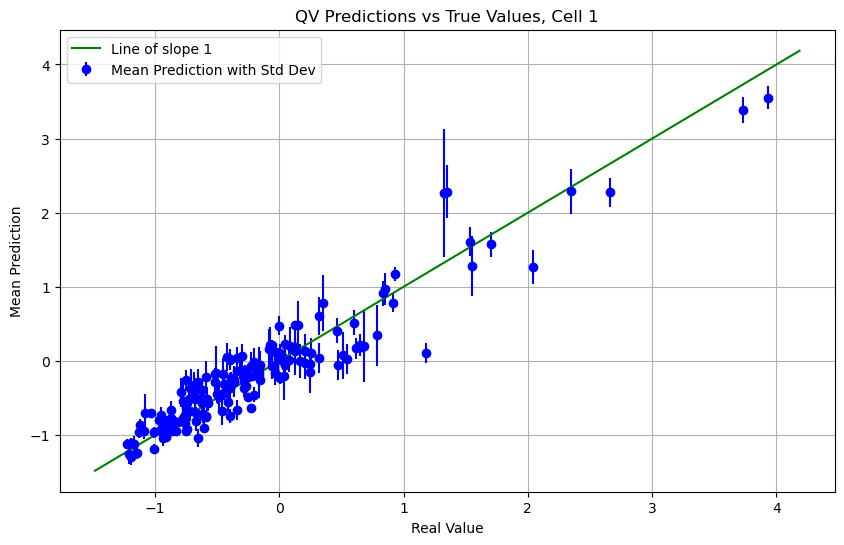

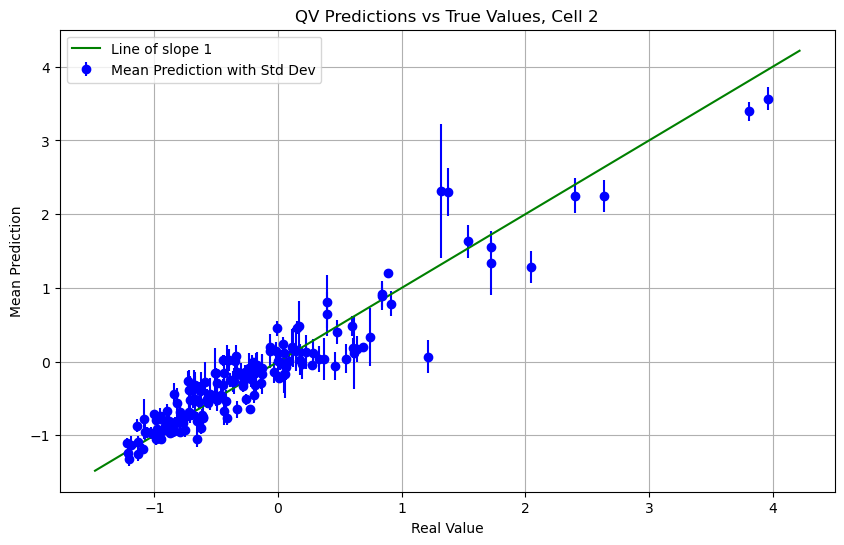

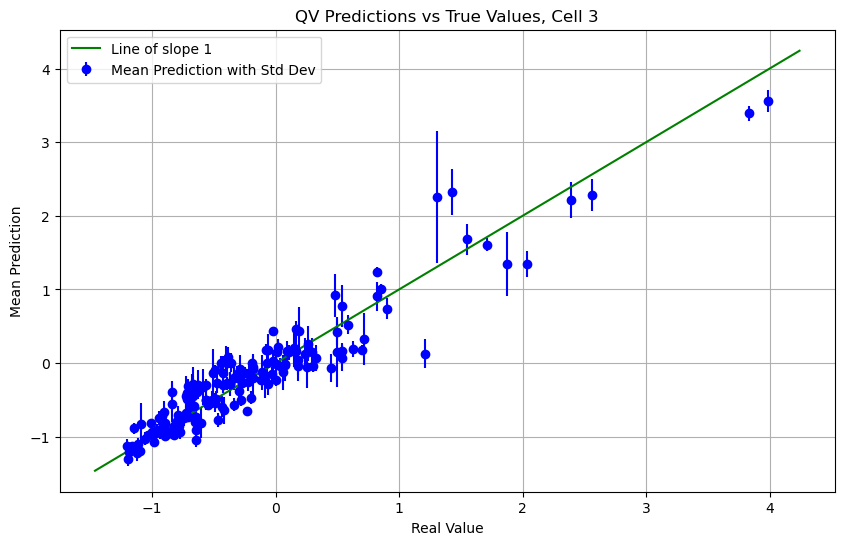

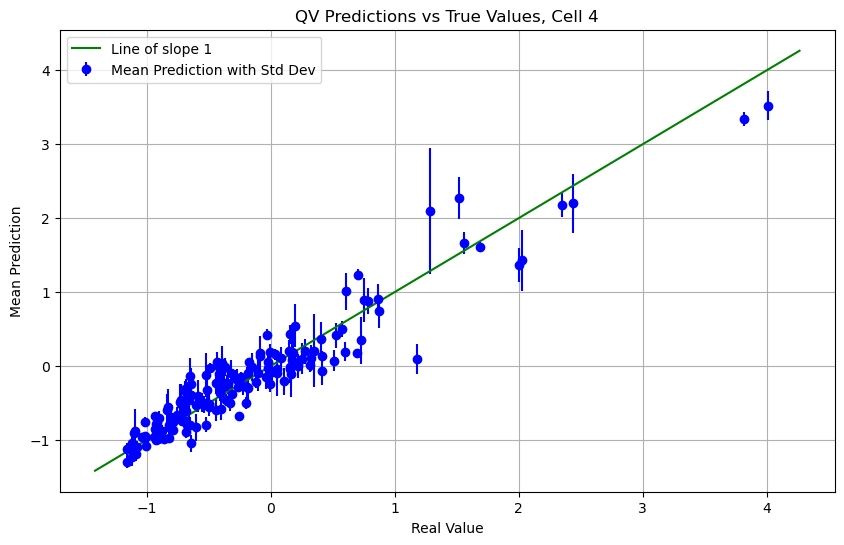

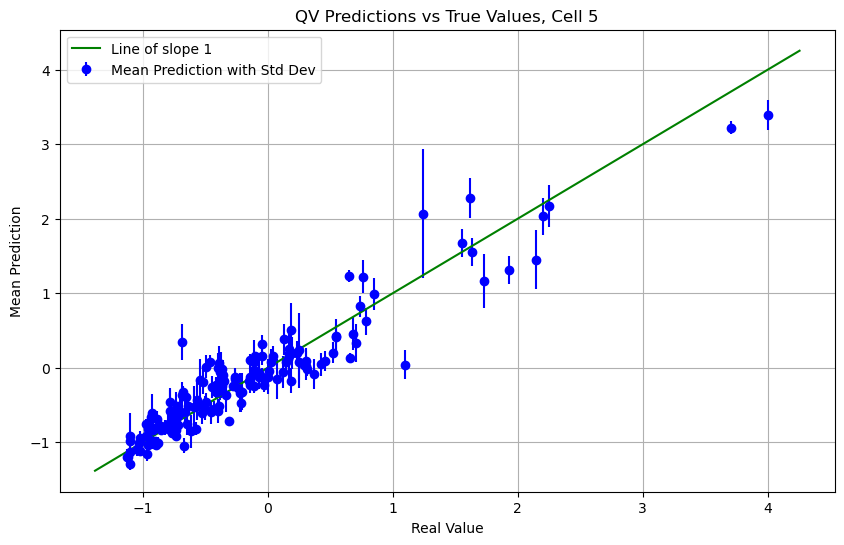

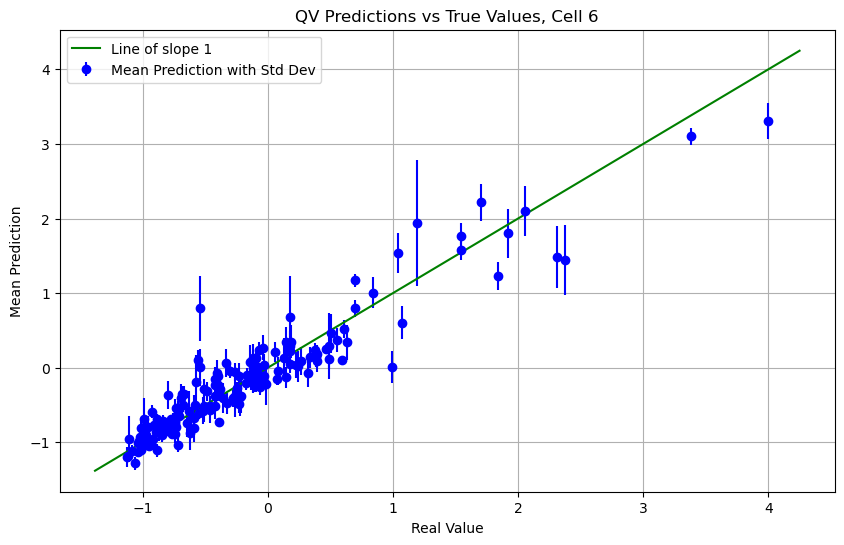

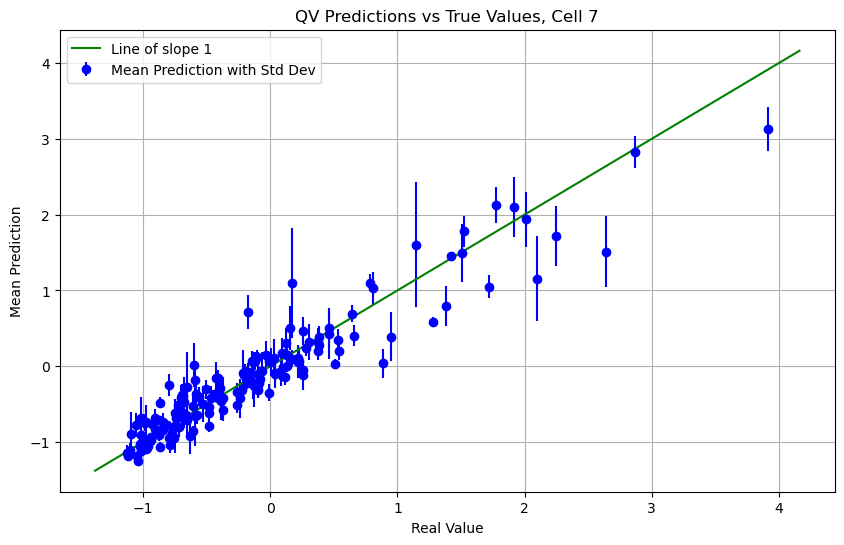

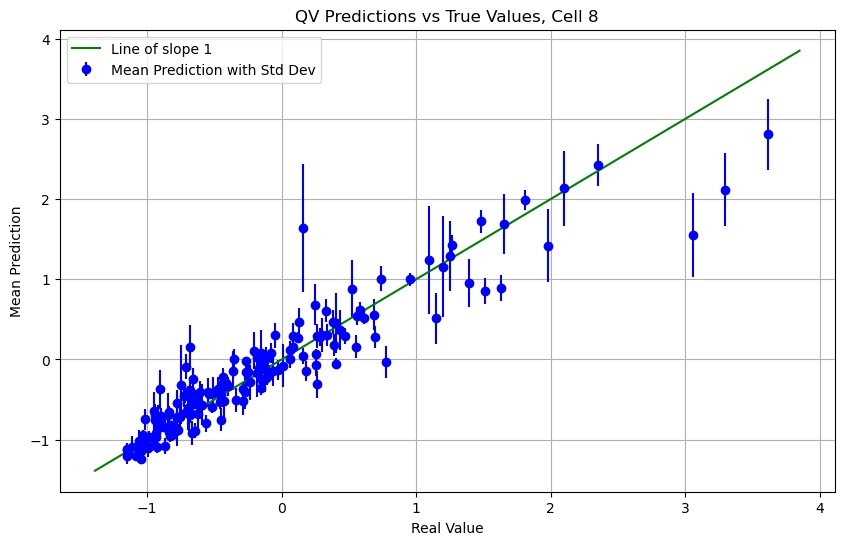

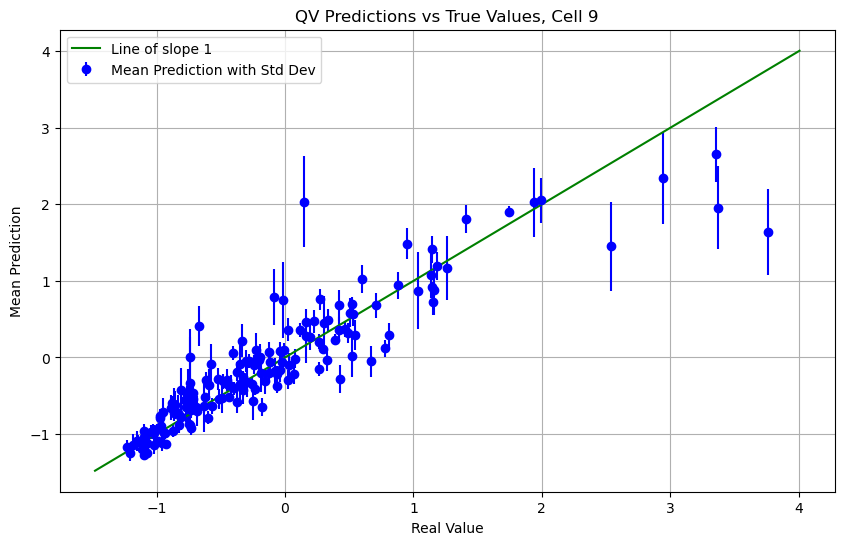

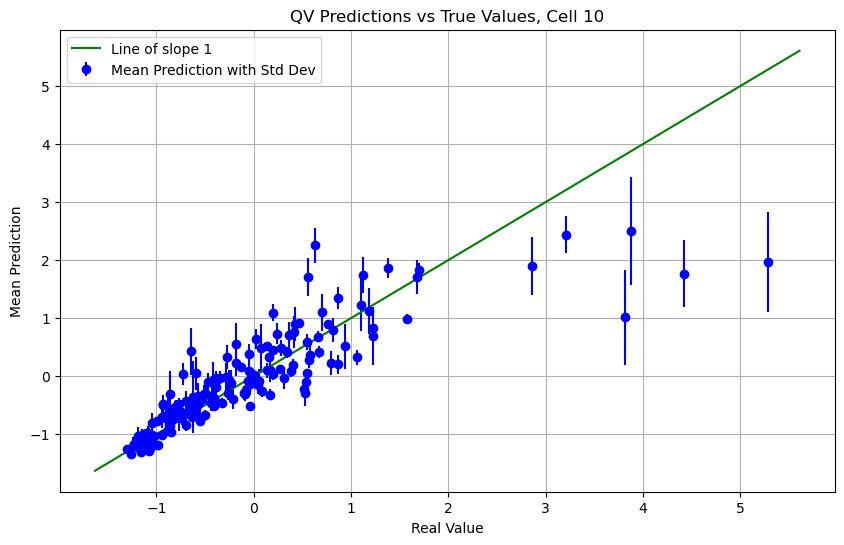

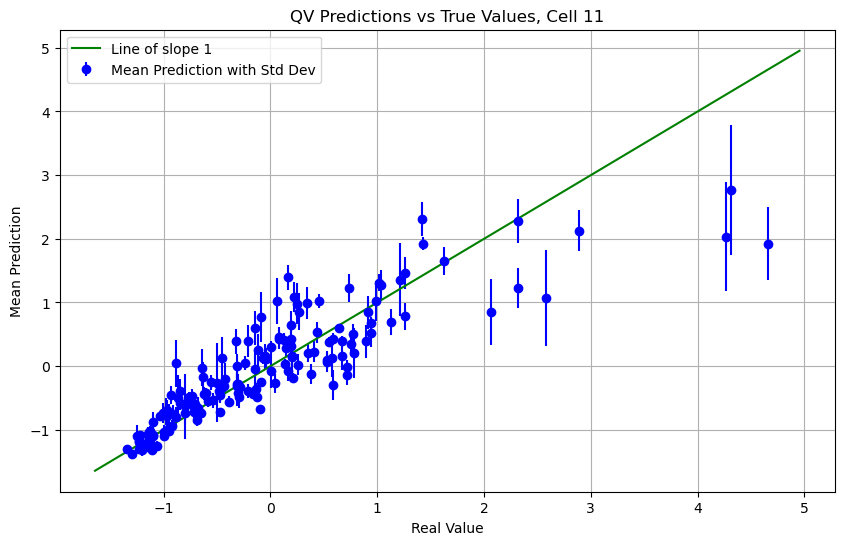

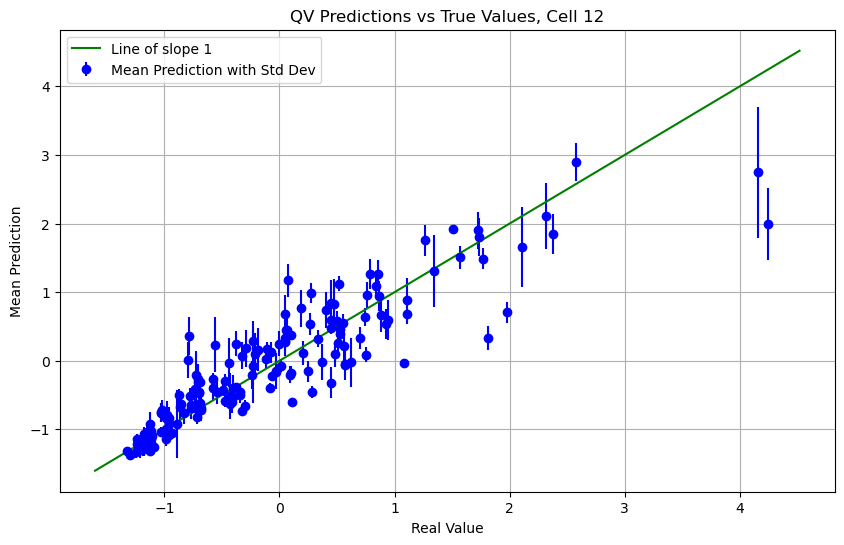

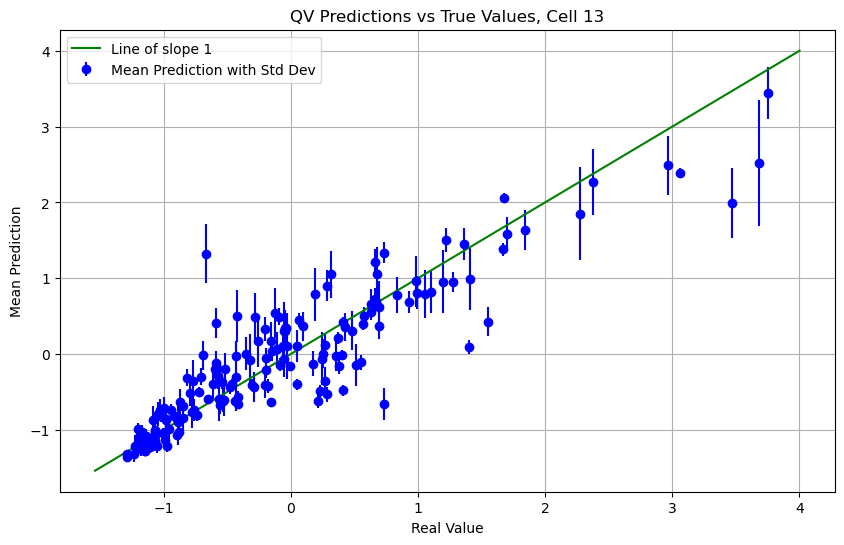

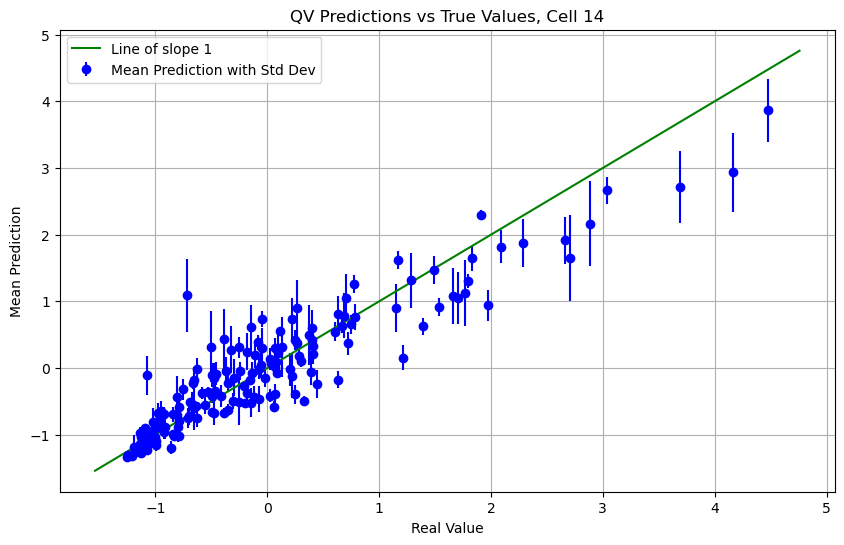

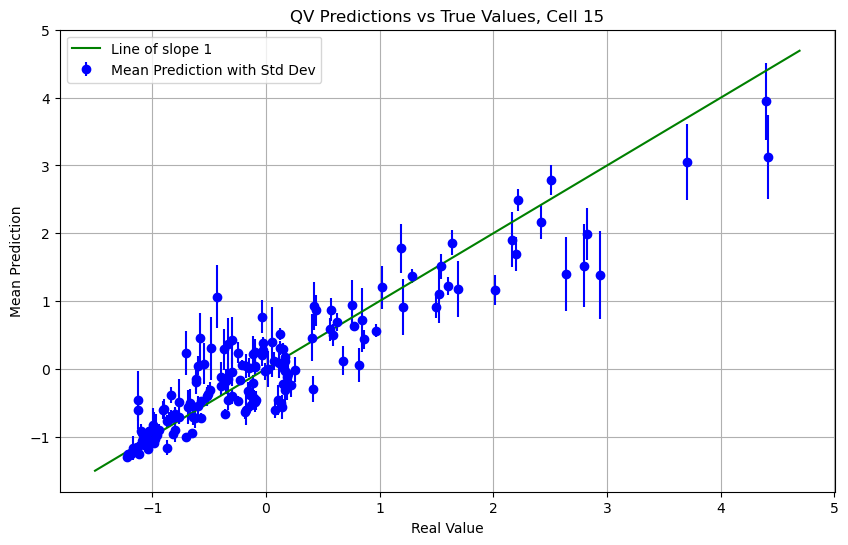

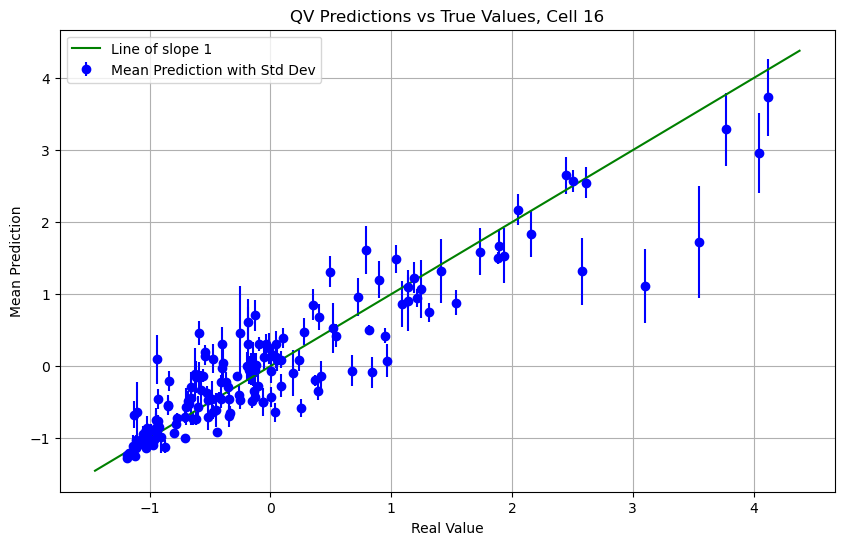

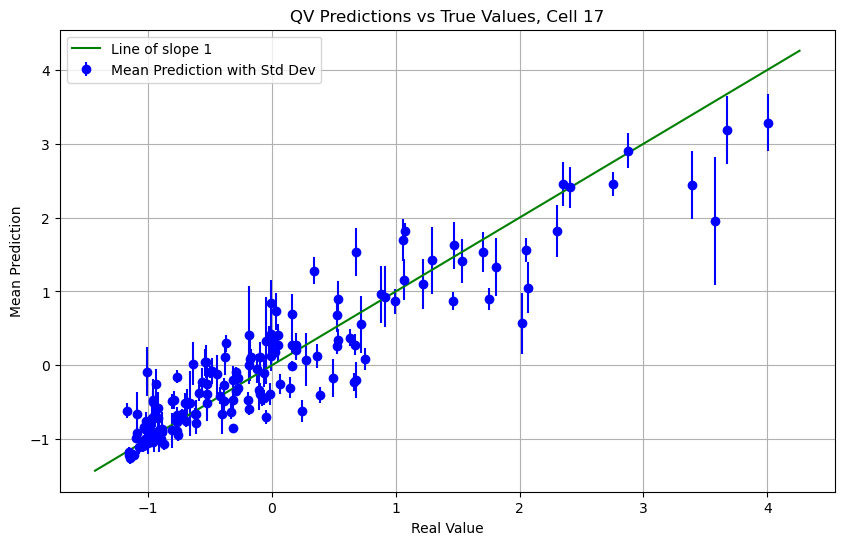

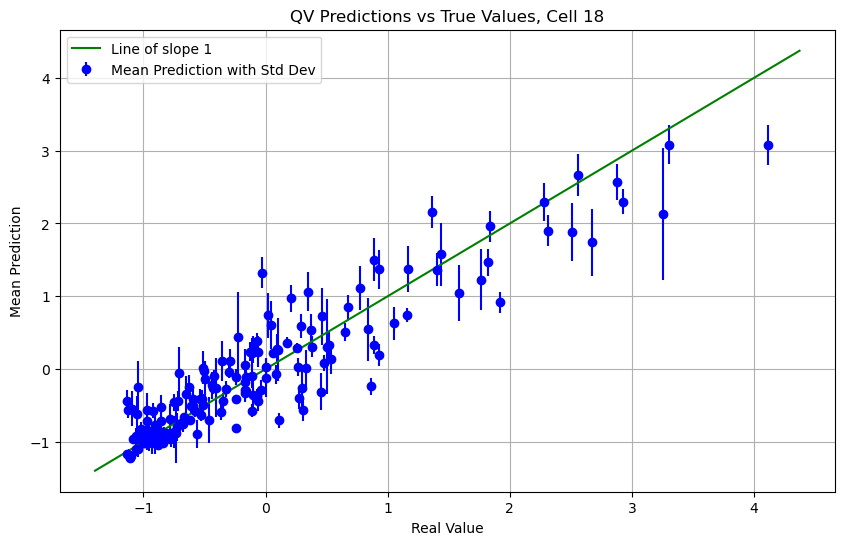

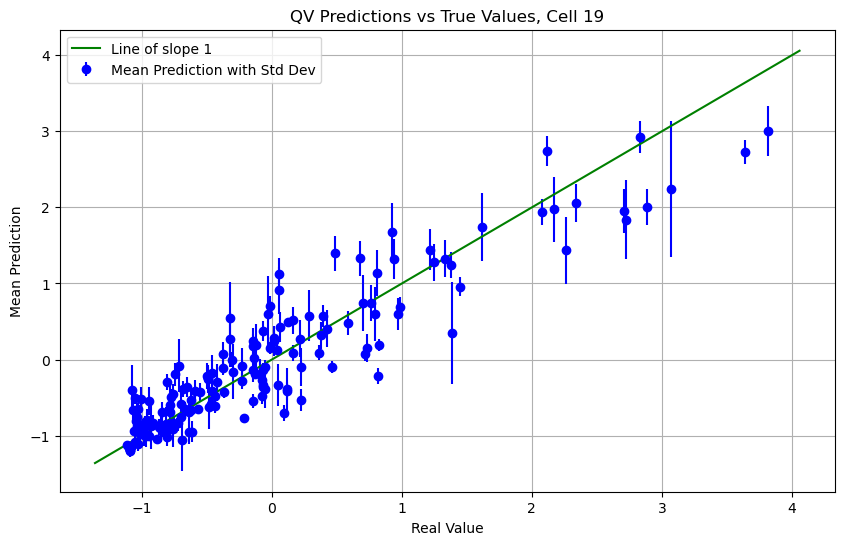

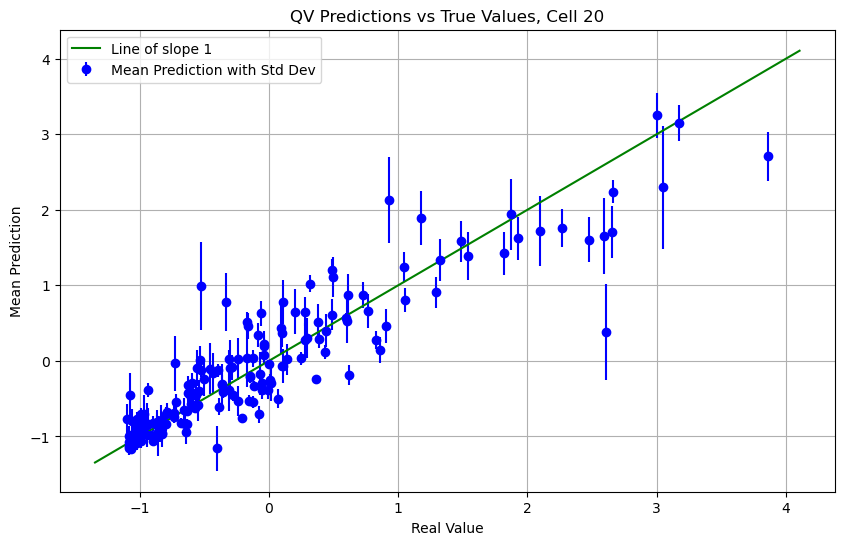

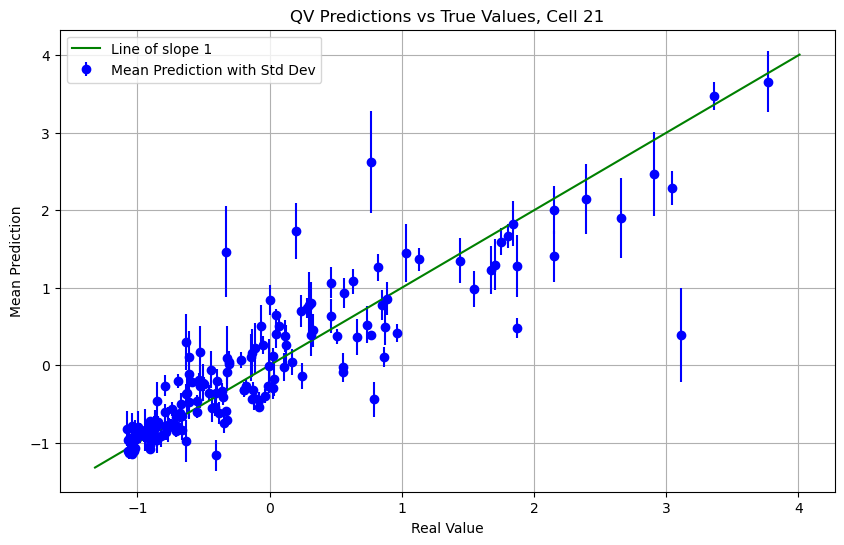

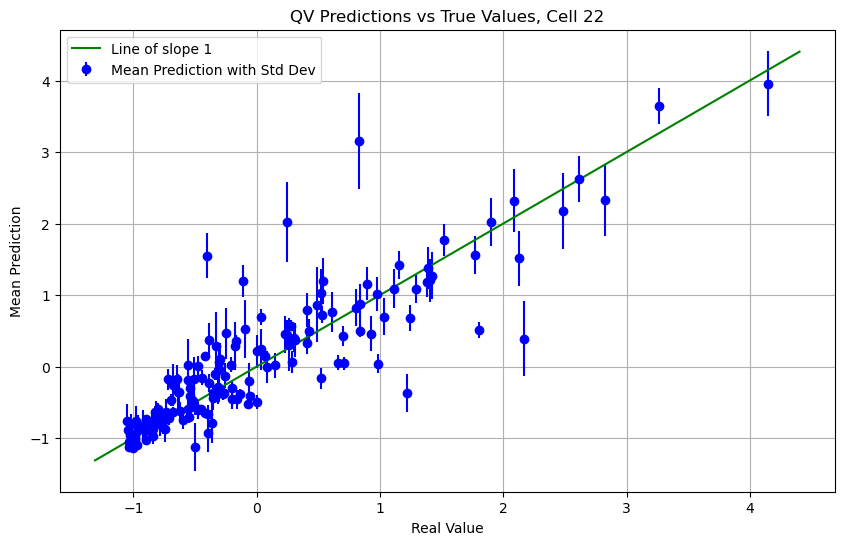

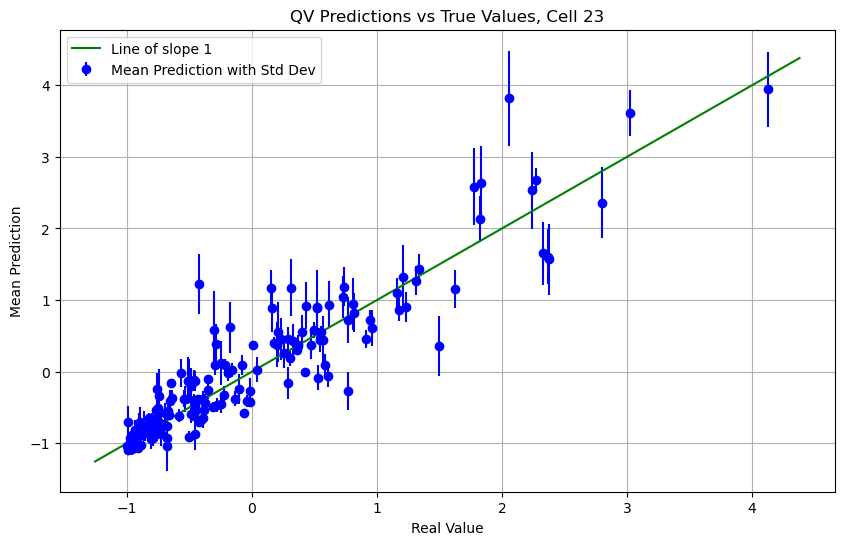

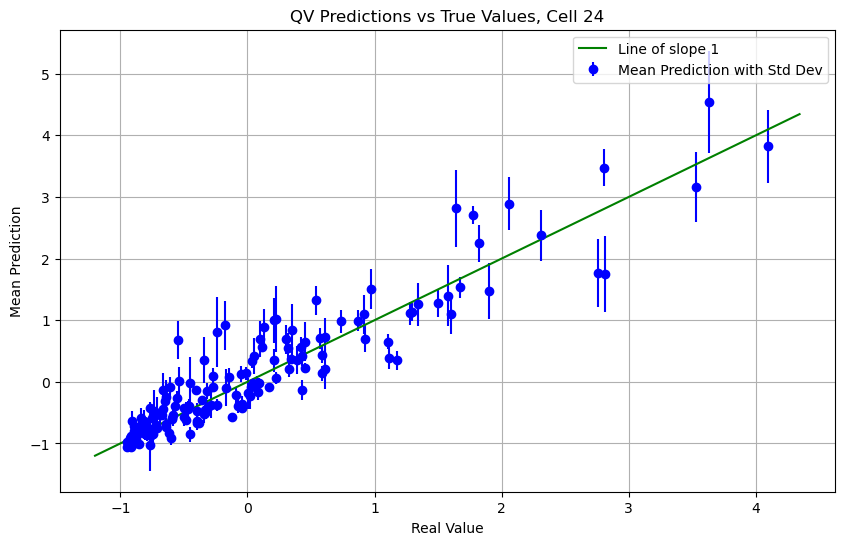

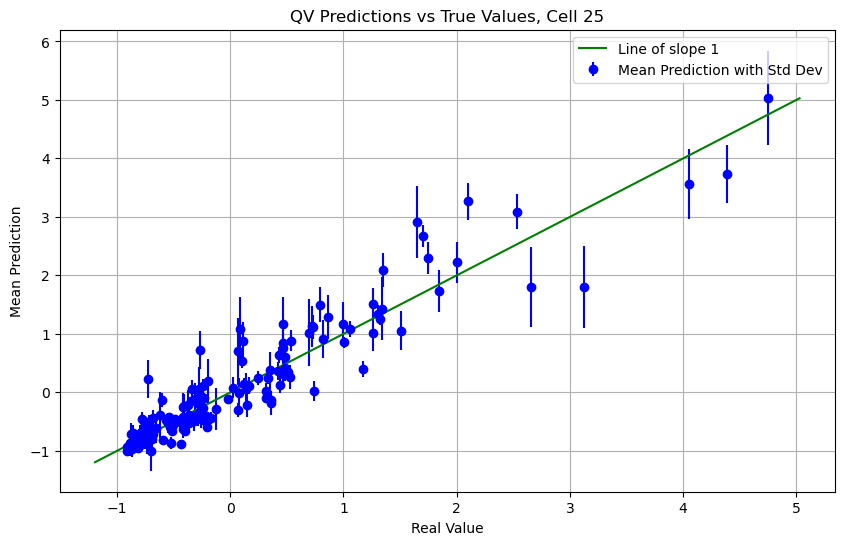

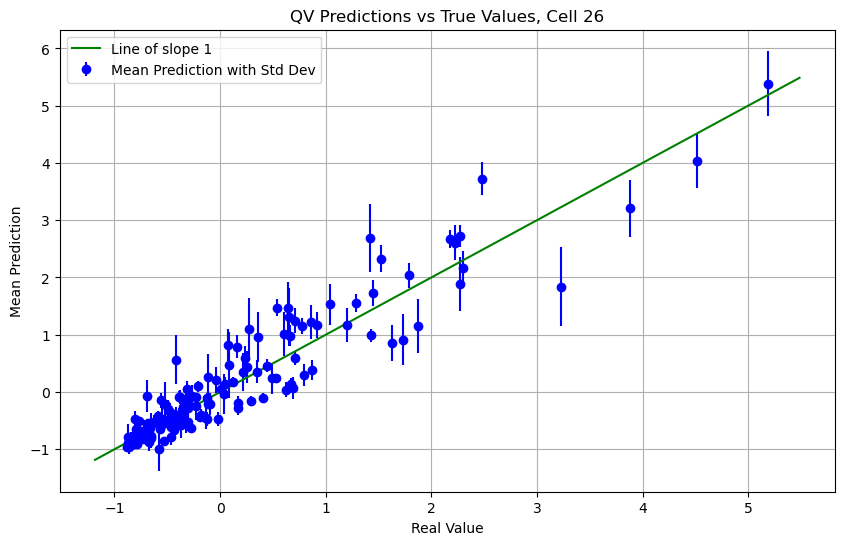

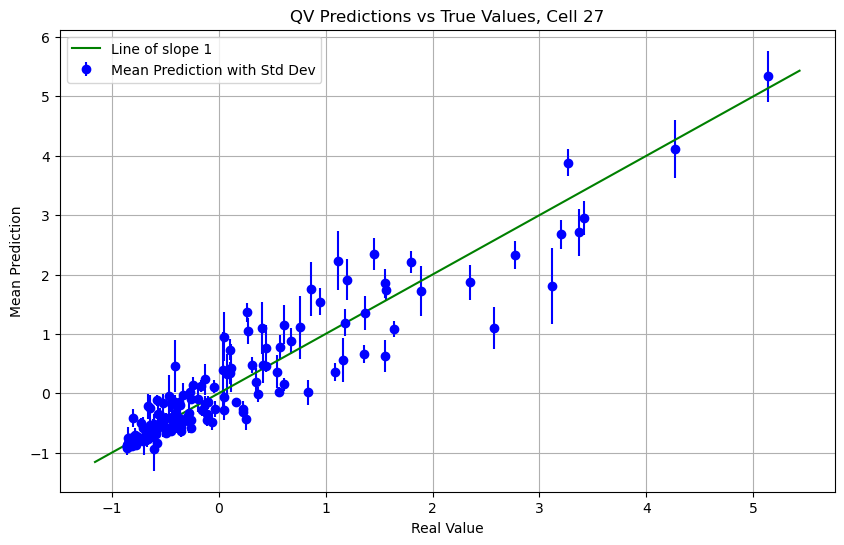

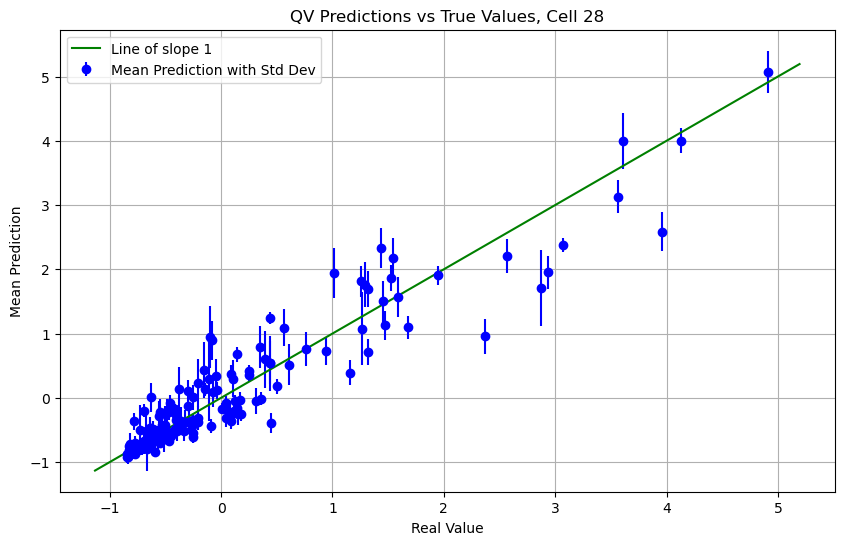

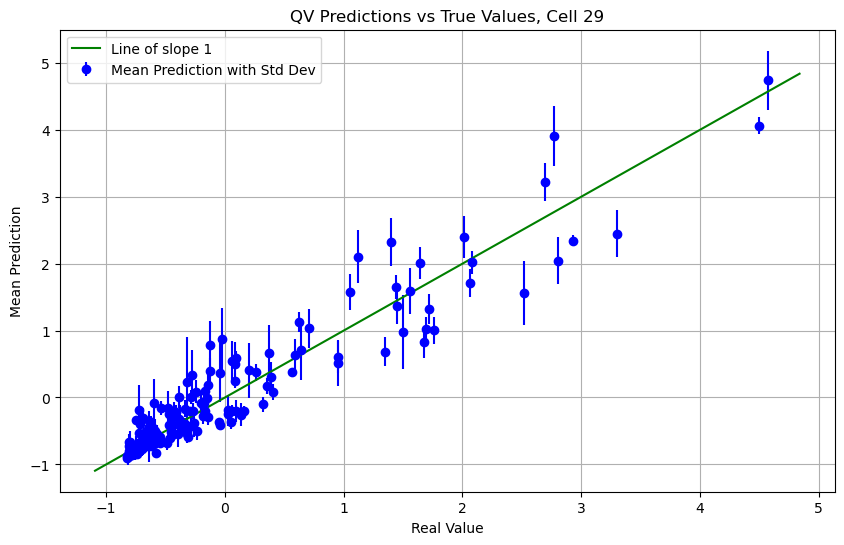

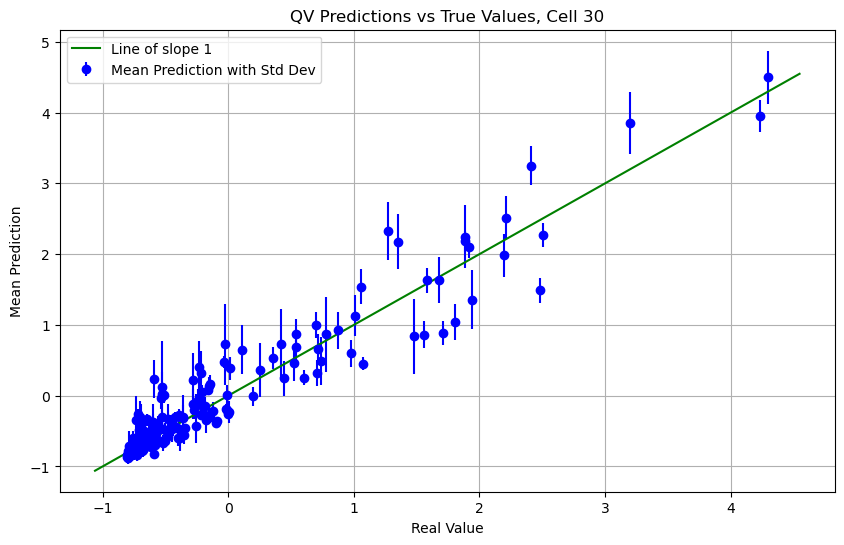

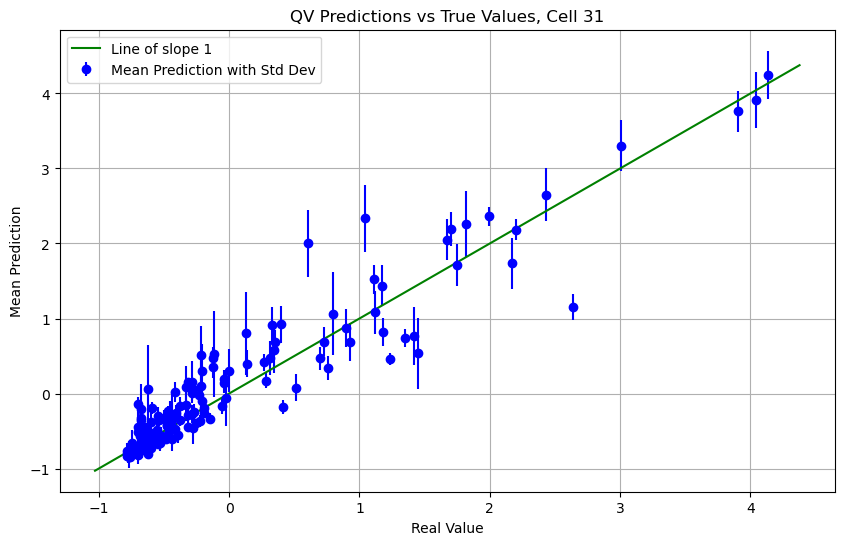

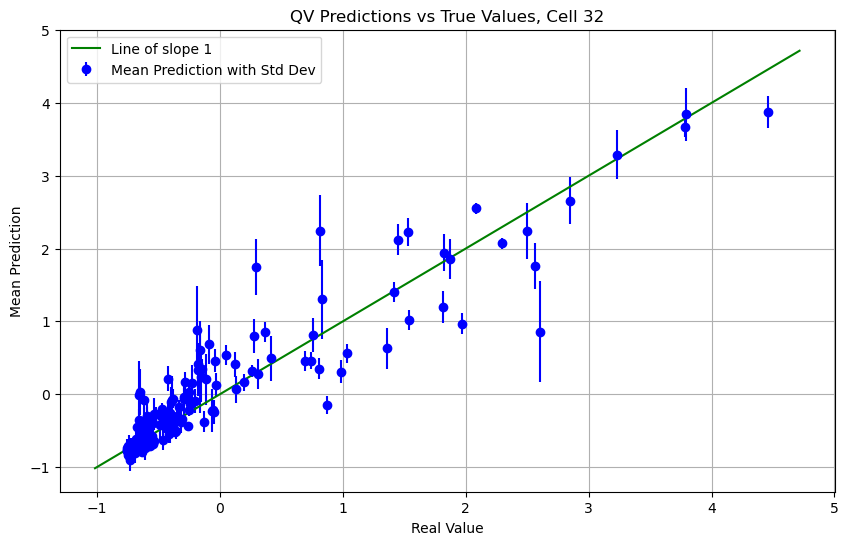

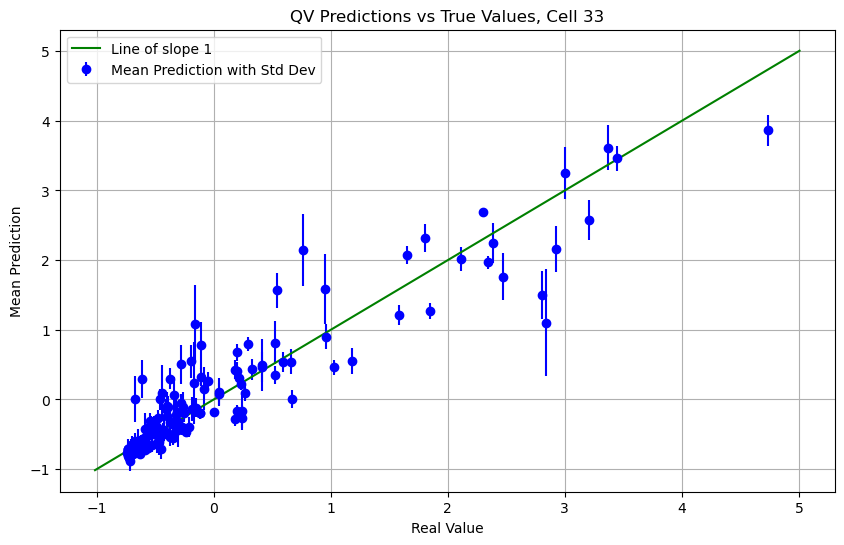

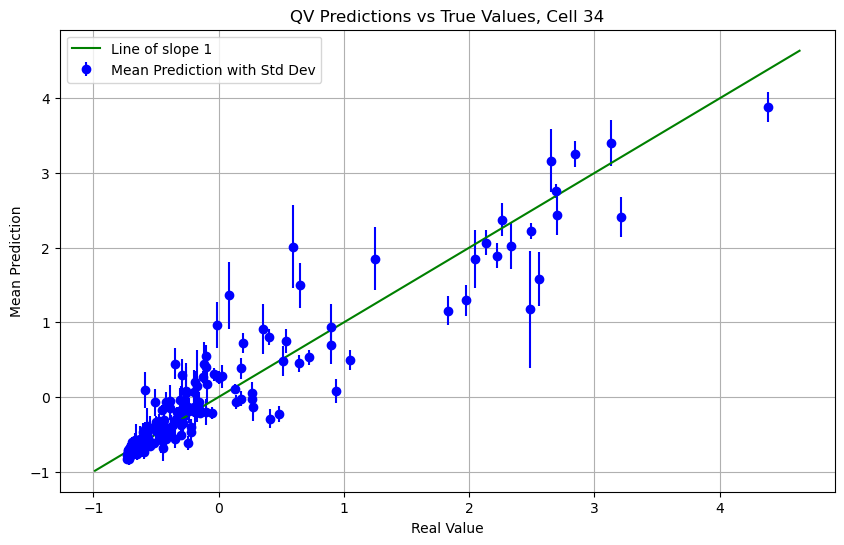

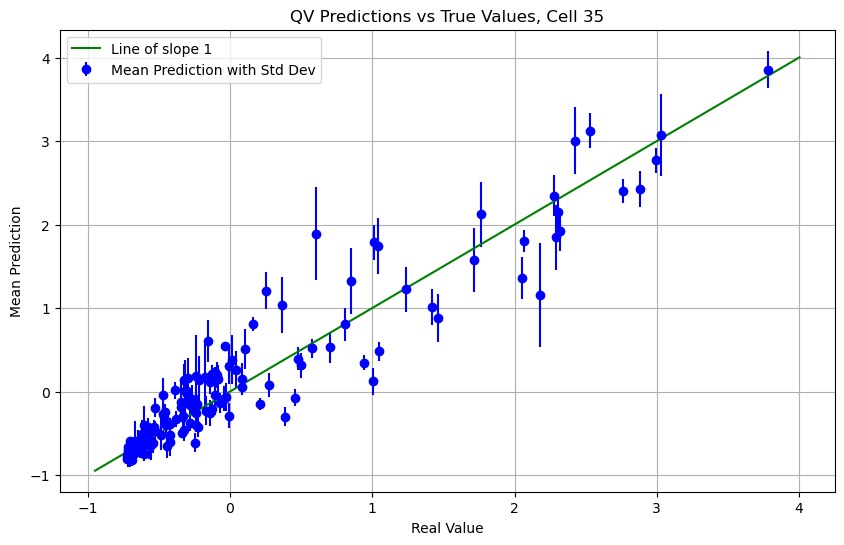

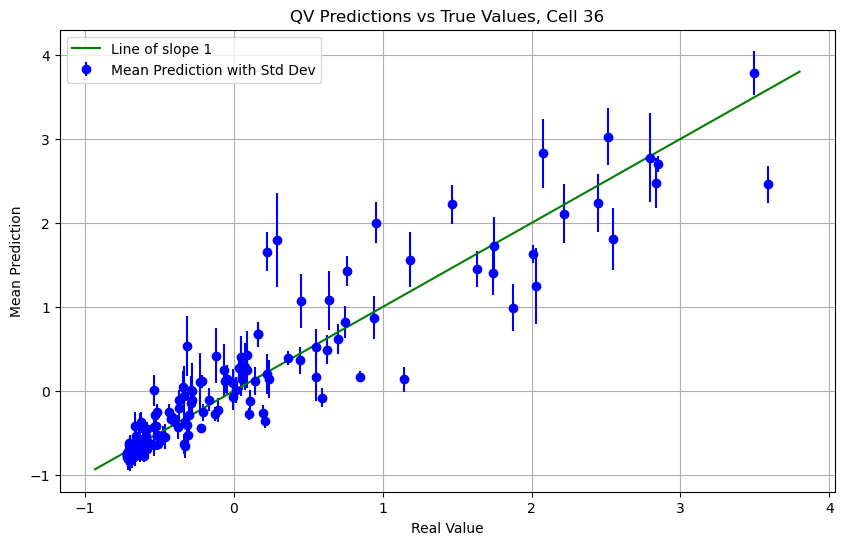

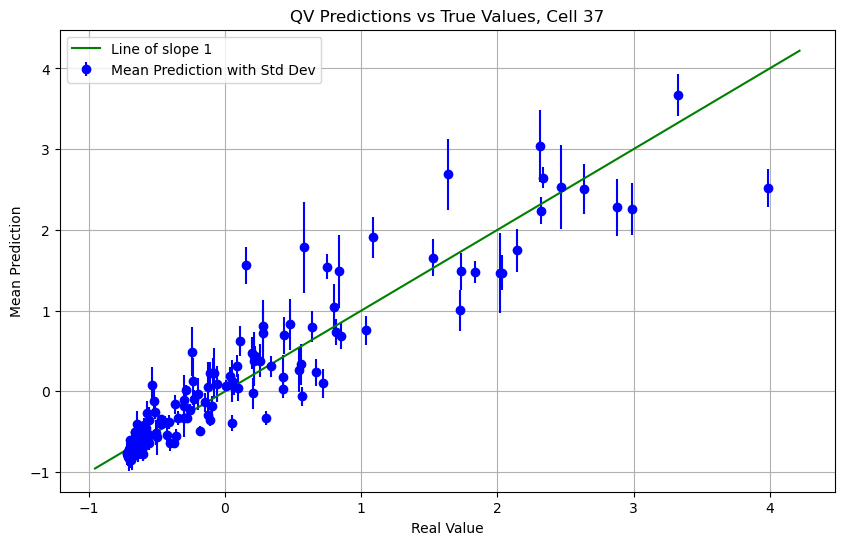

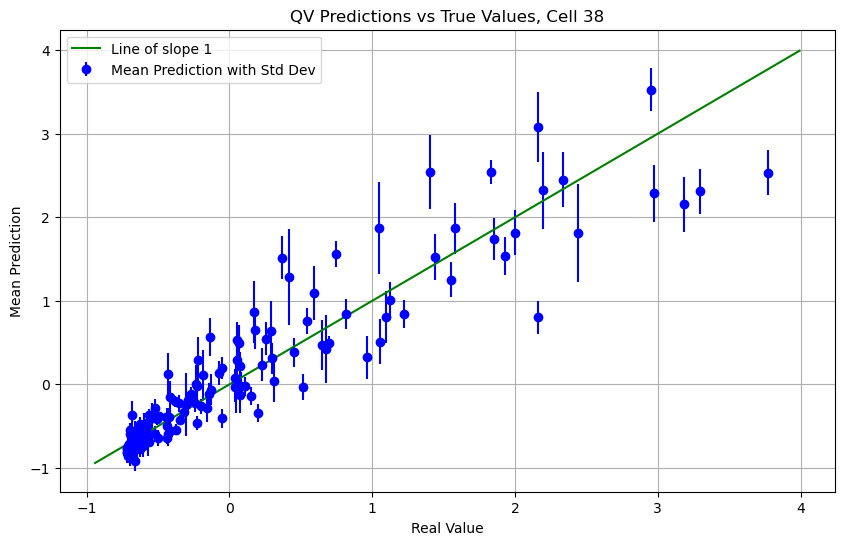

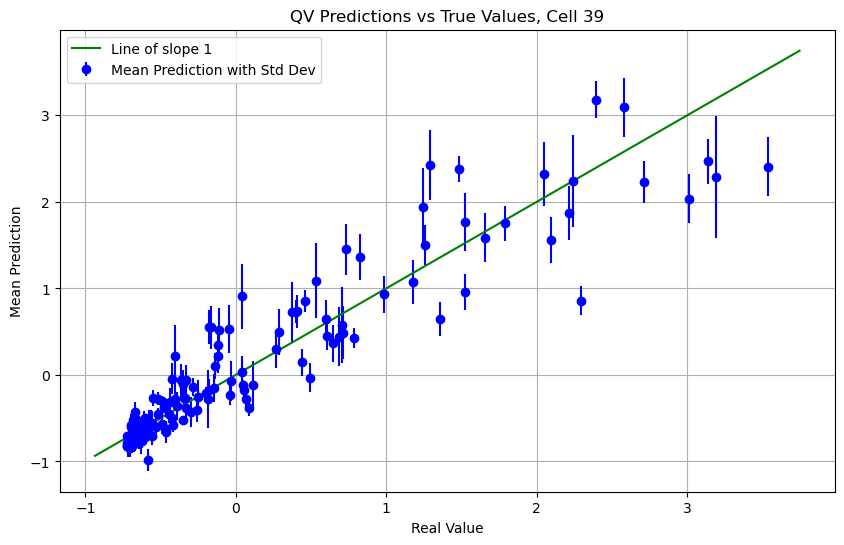

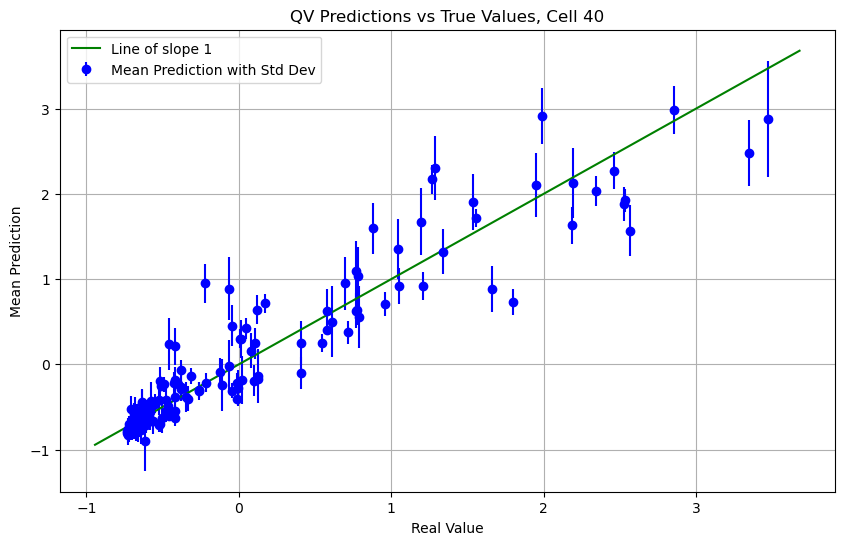

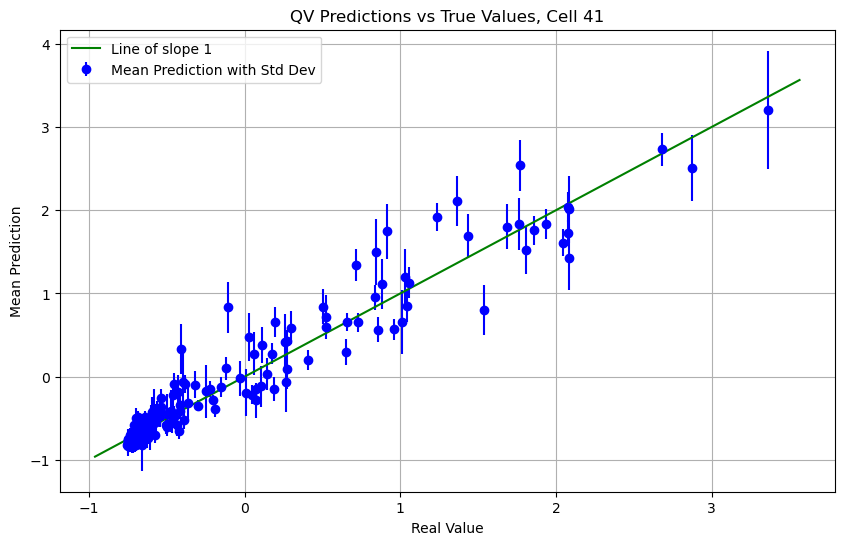

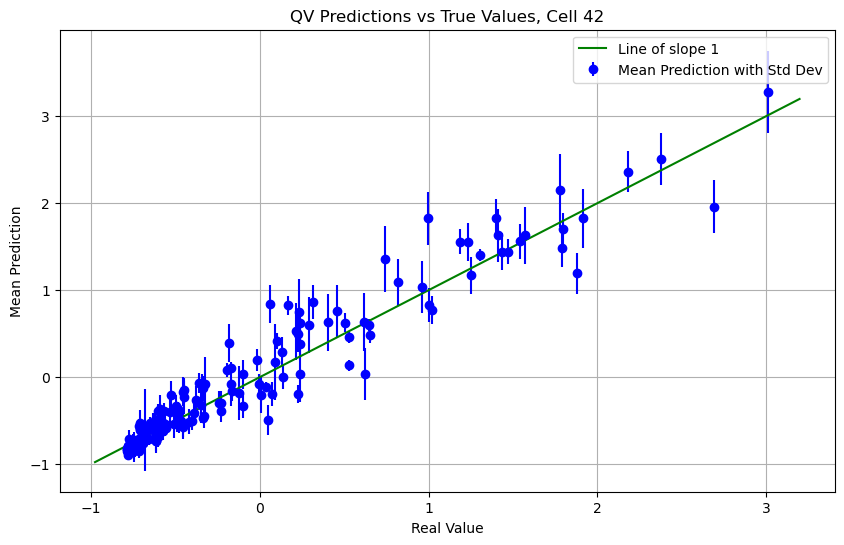

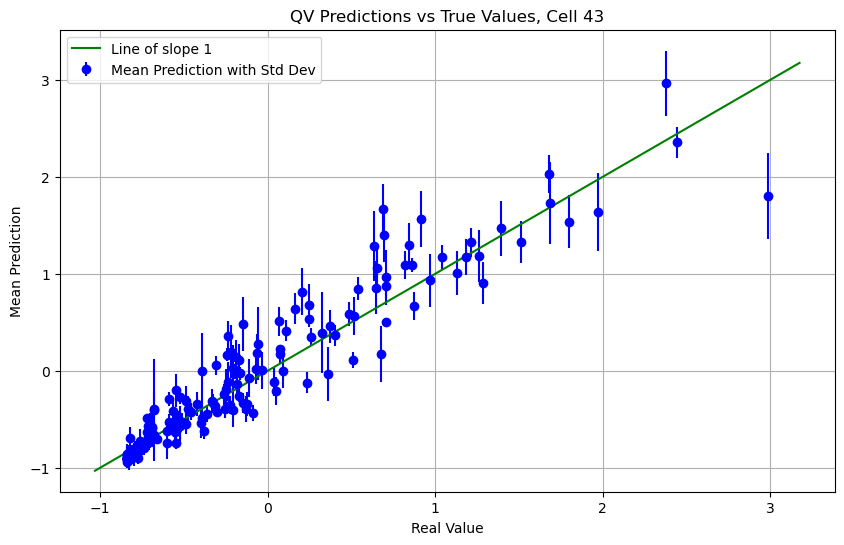

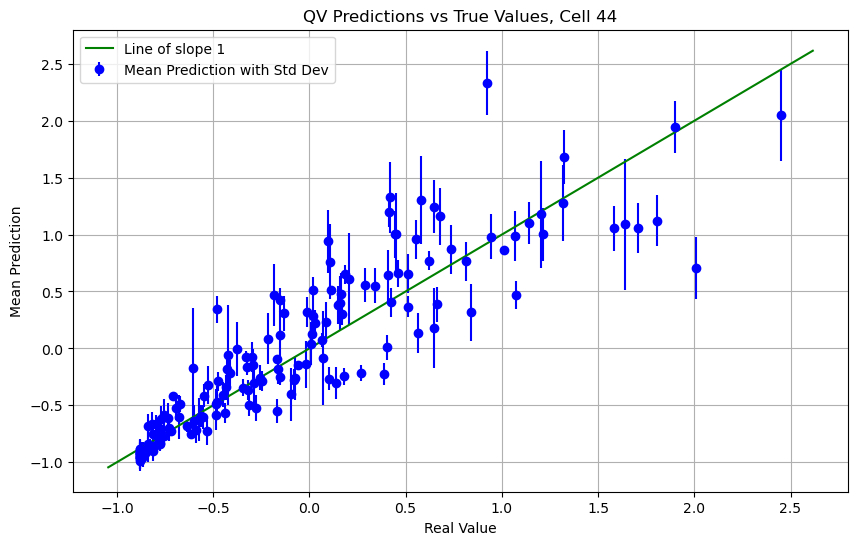

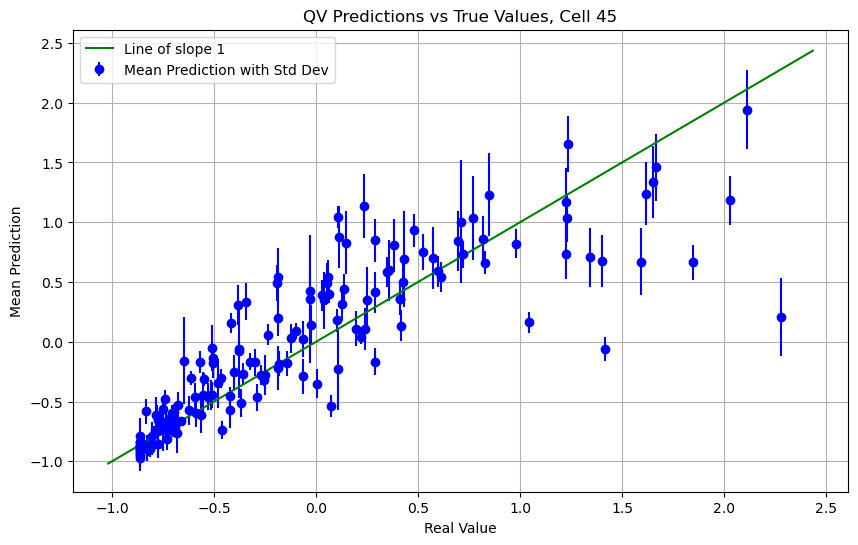

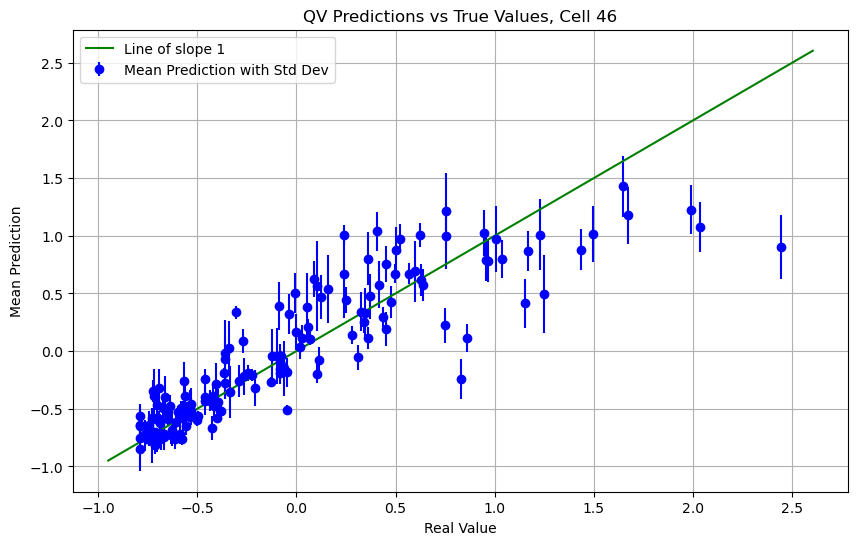

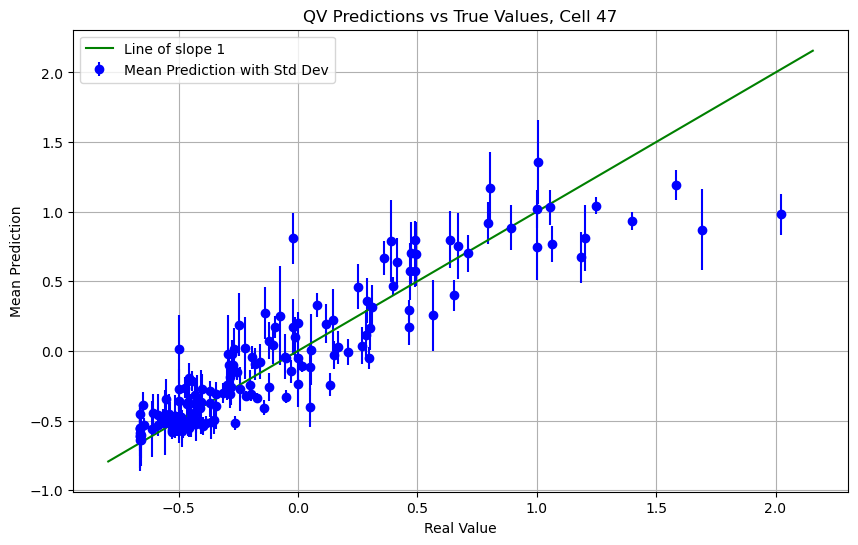

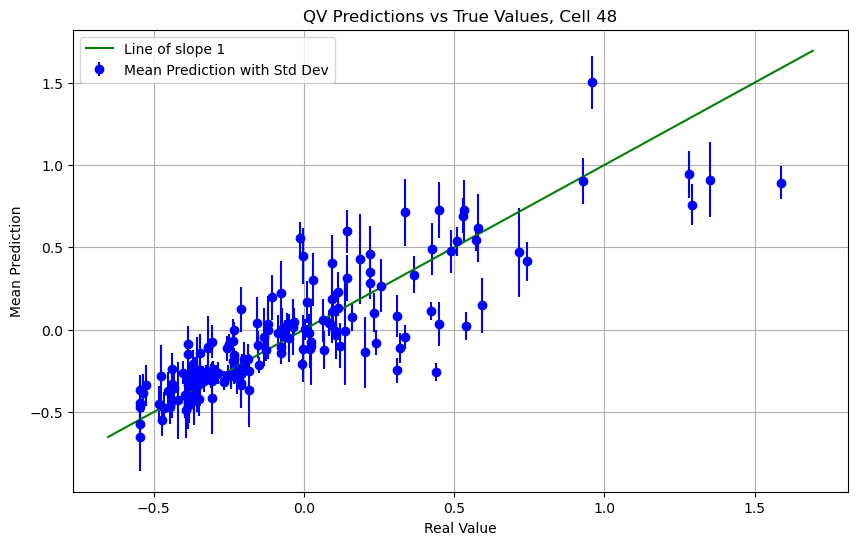

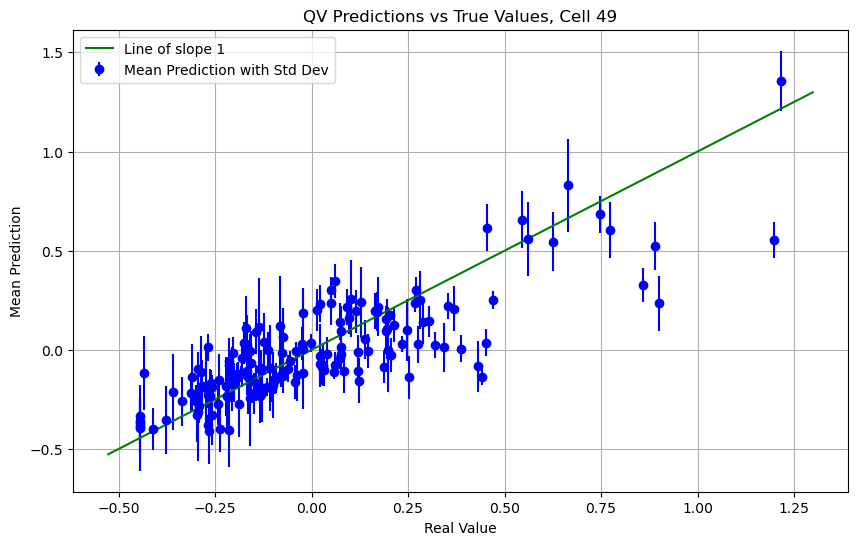

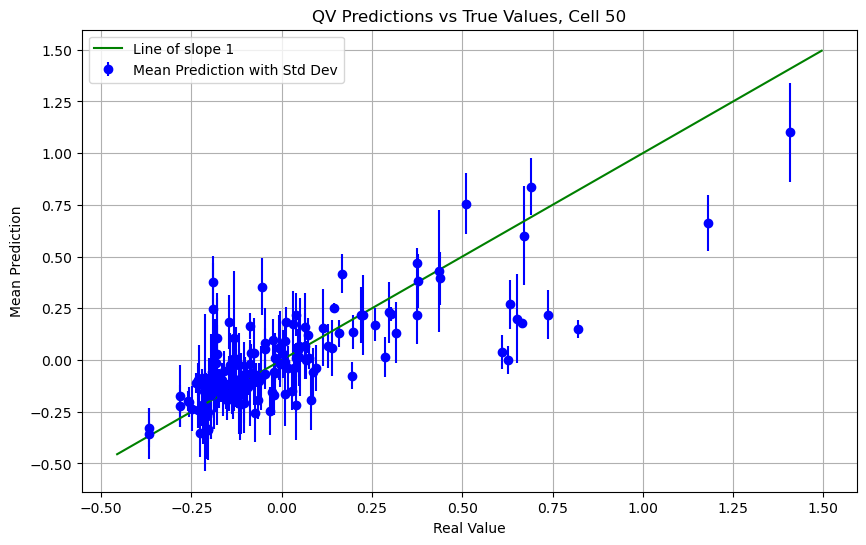

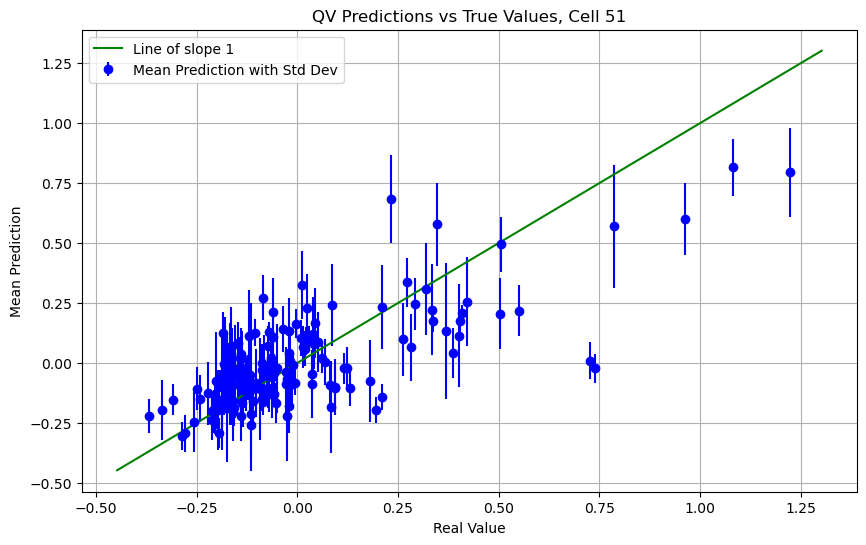

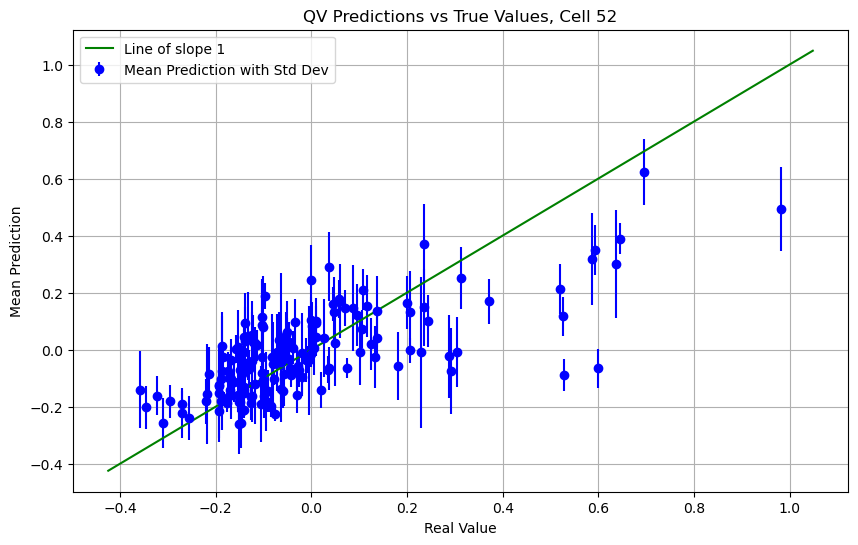

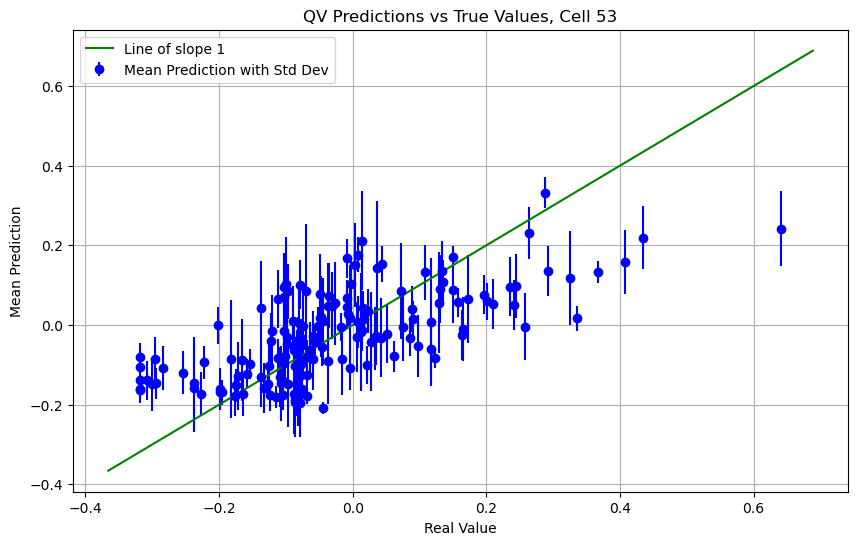

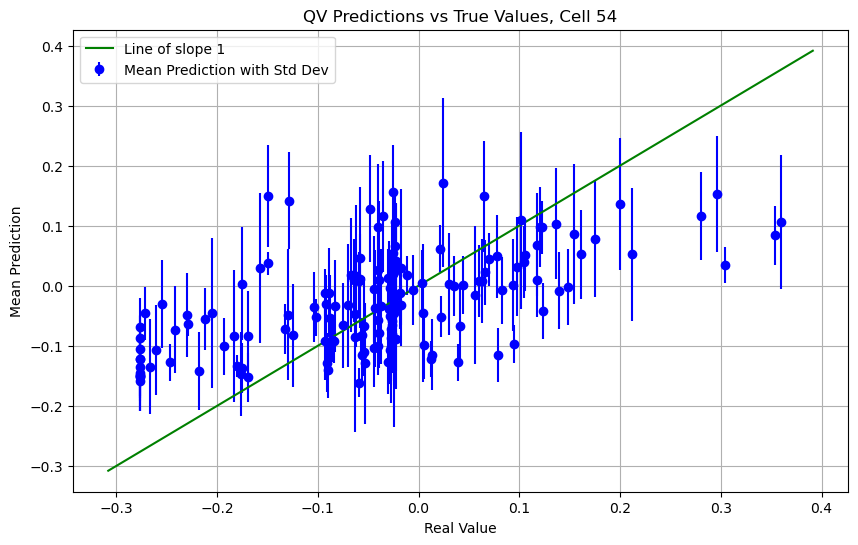

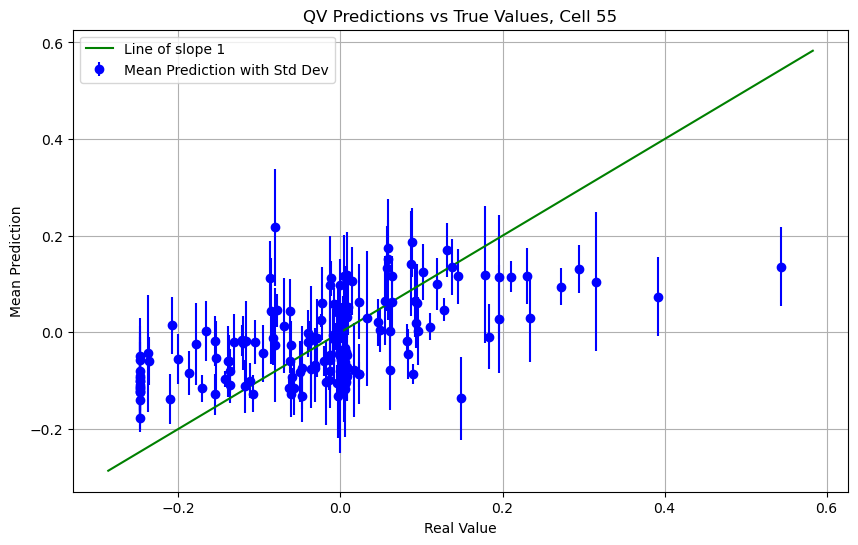

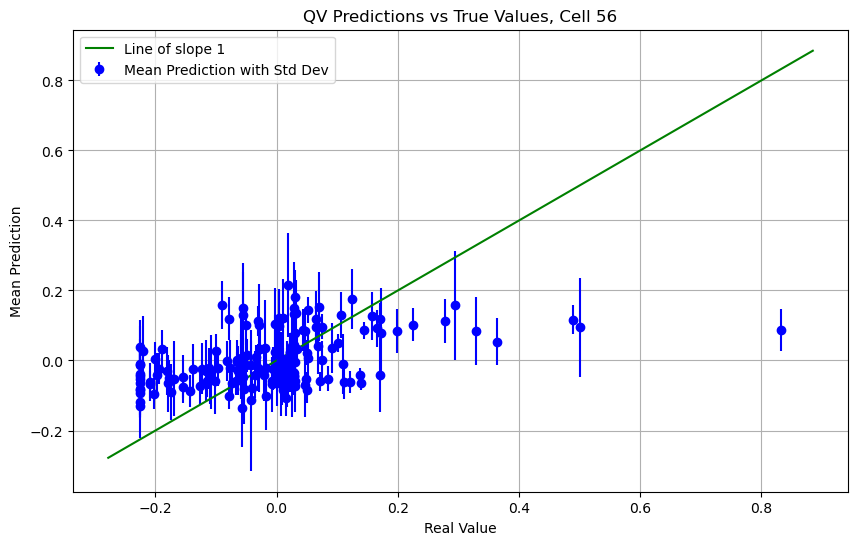

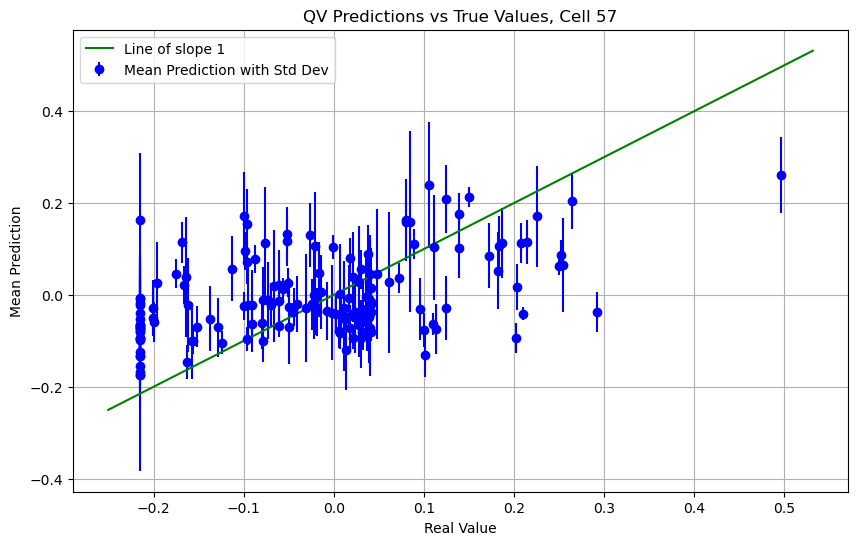

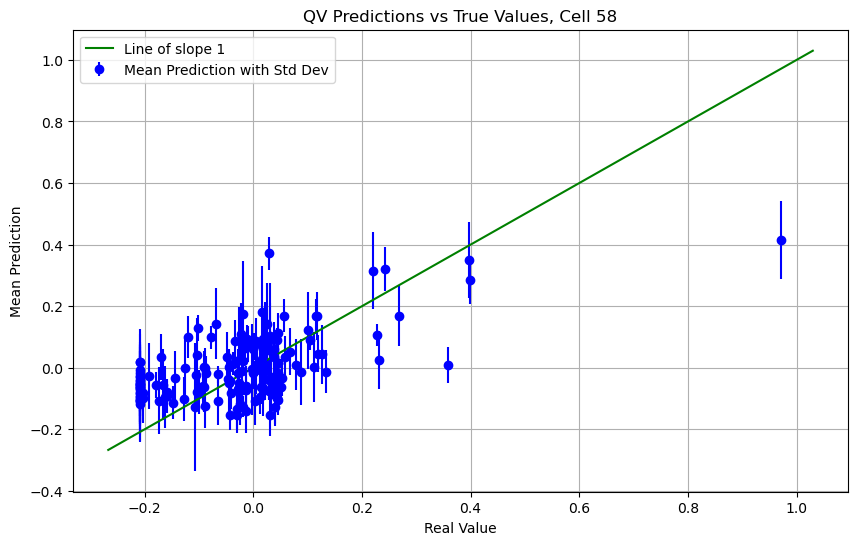

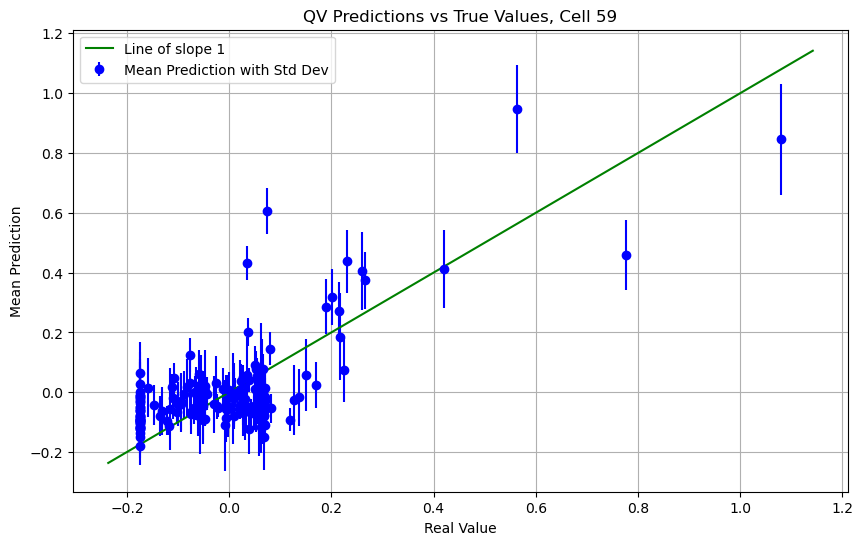

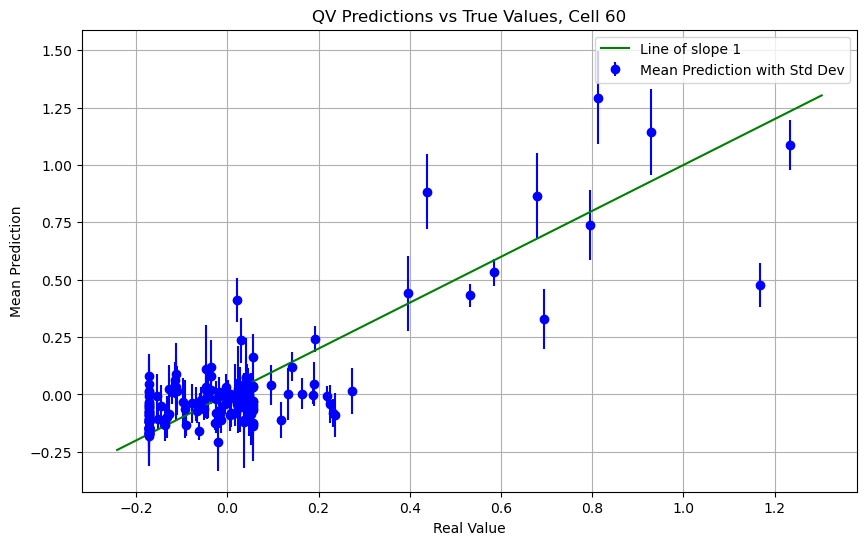

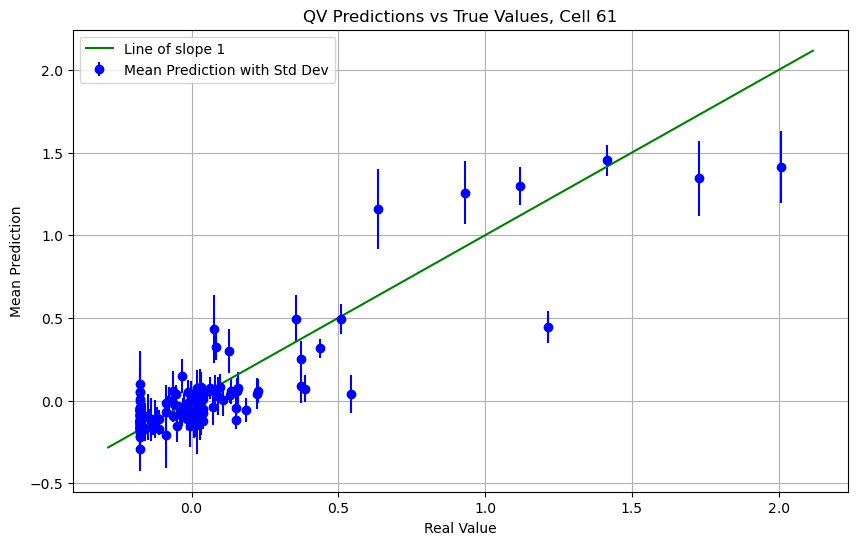

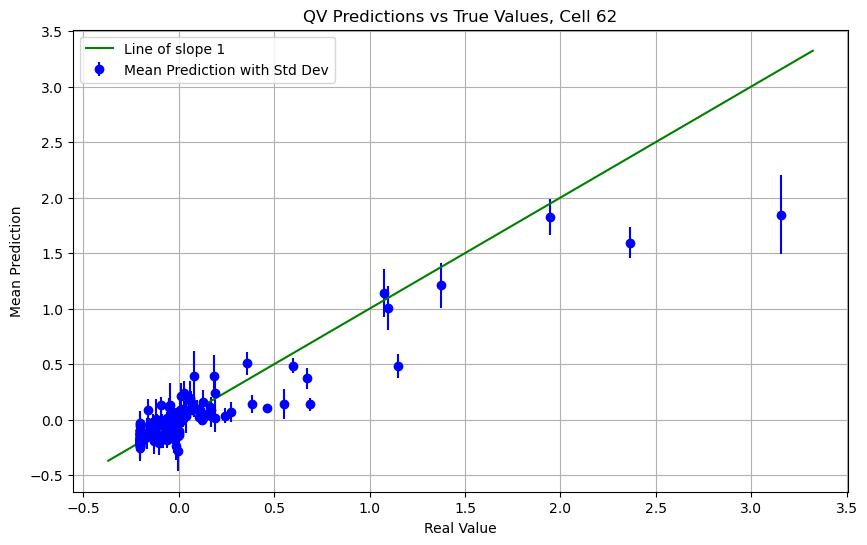

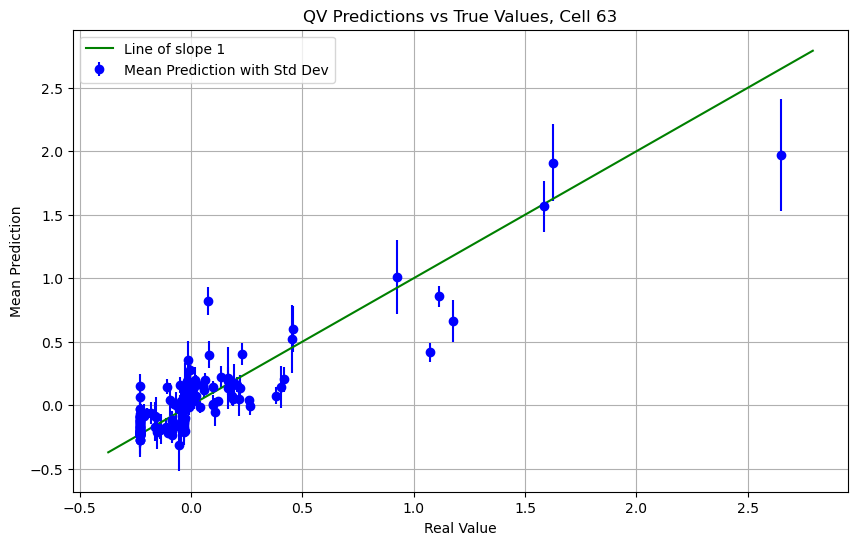

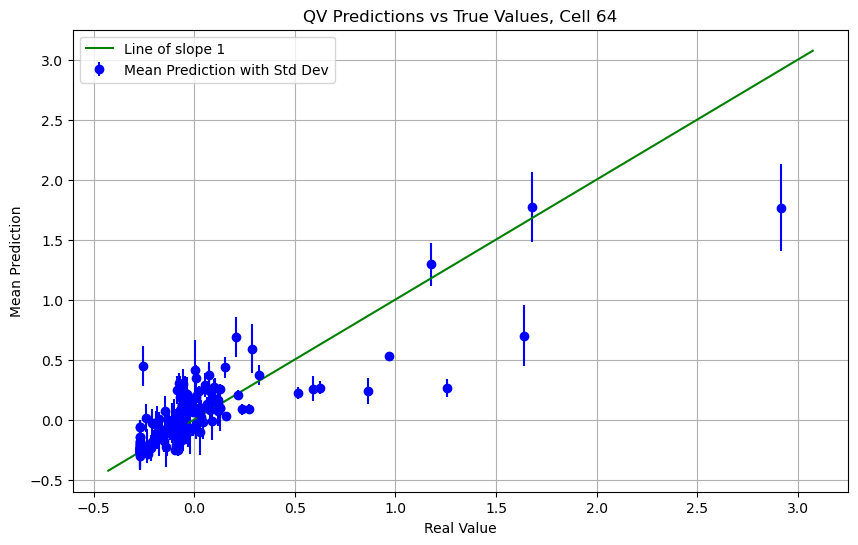

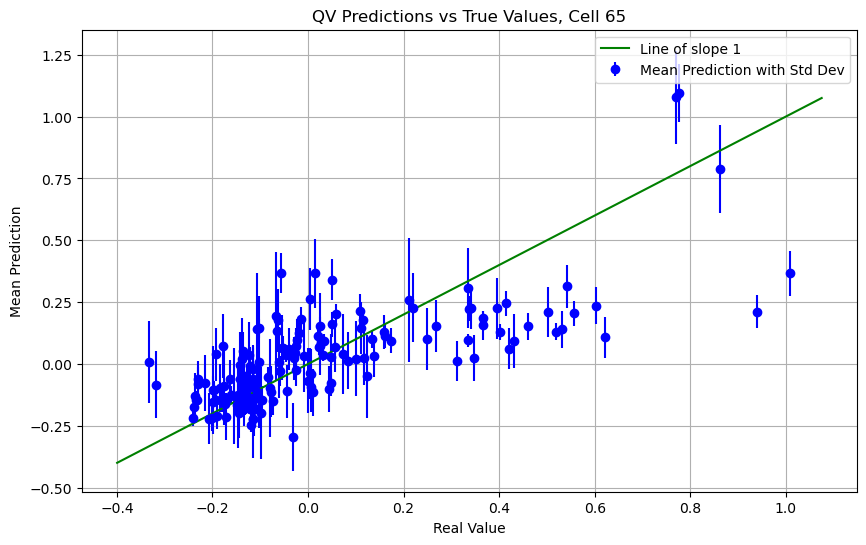

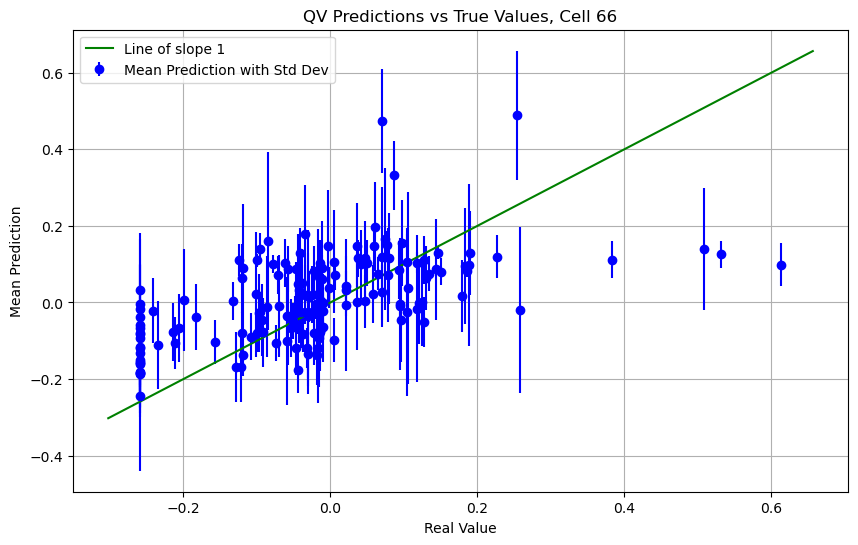

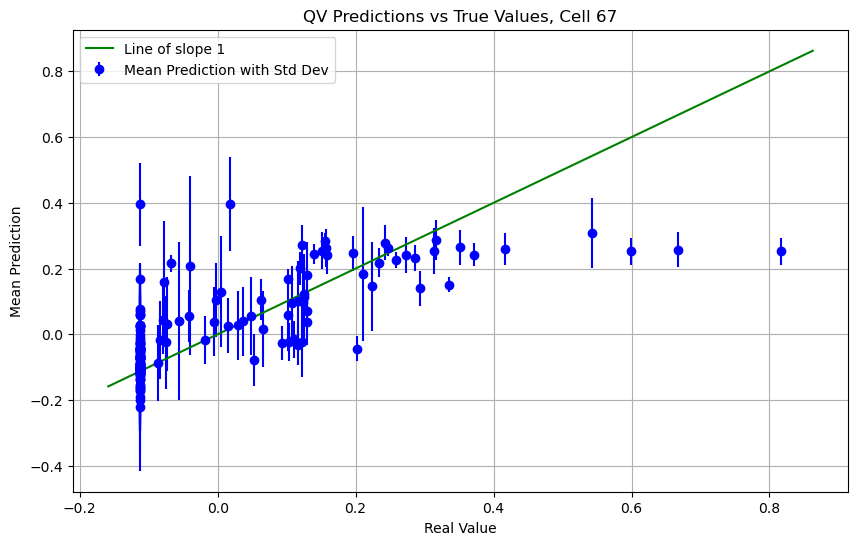

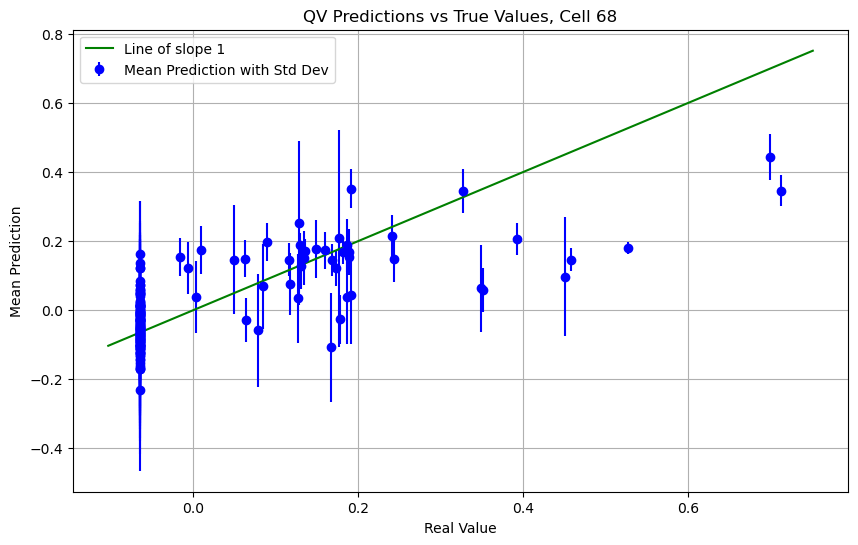

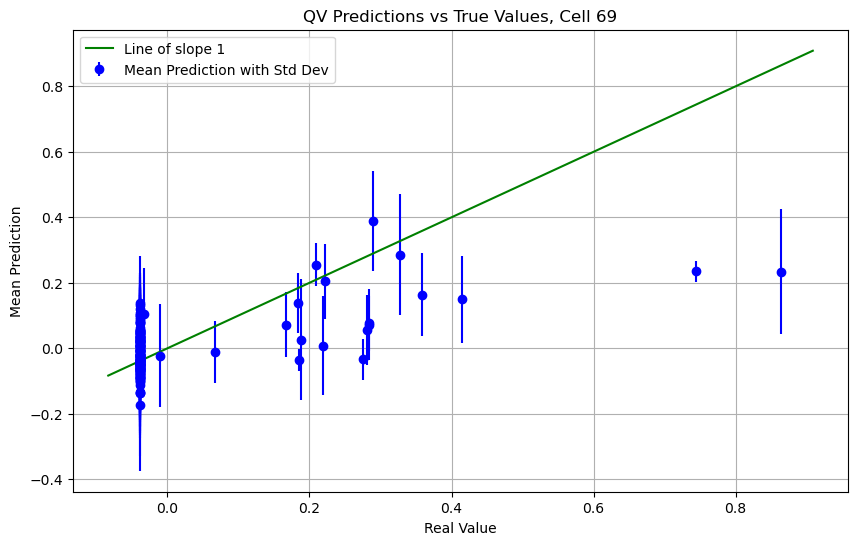

In [28]:
for i in range(70):
    plot_values = {}
    for k,v in model_preds.items():
        plot_values[k] = (slice_column(v[0], i), slice_column(v[1], i))
    plot_cell(plot_values, i, 1)